In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#load the data into pandas dataframes 
ca_fires = pd.read_csv('data/California_Fire_Incidents.csv')
fire_costs = pd.read_csv('data/Total Wildland Fires and Acres (1983-2020).csv')
global_fires = pd.read_csv('data/GlobalFireBurnedArea_2022 2.csv')

In [5]:
ca_fires.head()

,AcresBurned,Active,AdminUnit,AirTankers,ArchiveYear,CalFireIncident,CanonicalUrl,ConditionStatement,ControlStatement,Counties,...,SearchKeywords,Started,Status,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,UniqueId,Updated,WaterTenders
0,257314.0,False,Stanislaus National Forest/Yosemite National Park,NaN,2013,True,/incidents/2013/8/17/rim-fire/,NaN,NaN,Tuolumne,...,"Rim Fire, Stanislaus National Forest, Yosemite...",2013-08-17T15:25:00Z,Finalized,NaN,NaN,NaN,NaN,5fb18d4d-213f-4d83-a179-daaf11939e78,2013-09-06T18:30:00Z,NaN
1,30274.0,False,USFS Angeles National Forest/Los Angeles Count...,NaN,2013,True,/incidents/2013/5/30/powerhouse-fire/,NaN,NaN,Los Angeles,...,"Powerhouse Fire, May 2013, June 2013, Angeles ...",2013-05-30T15:28:00Z,Finalized,NaN,NaN,NaN,NaN,bf37805e-1cc2-4208-9972-753e47874c87,2013-06-08T18:30:00Z,NaN
2,27531.0,False,CAL FIRE Riverside Unit / San Bernardino Natio...,NaN,2013,True,/incidents/2013/7/15/mountain-fire/,NaN,NaN,Riverside,...,"Mountain Fire, July 2013, Highway 243, Highway...",2013-07-15T13:43:00Z,Finalized,NaN,NaN,NaN,NaN,a3149fec-4d48-427c-8b2c-59e8b79d59db,2013-07-30T18:00:00Z,NaN
3,27440.0,False,Tahoe National Forest,NaN,2013,False,/incidents/2013/8/10/american-fire/,NaN,NaN,Placer,...,"American Fire, August 2013, Deadwood Ridge, Fo...",2013-08-10T16:30:00Z,Finalized,NaN,NaN,NaN,NaN,8213f5c7-34fa-403b-a4bc-da2ace6e6625,2013-08-30T08:00:00Z,NaN
4,24251.0,False,Ventura County Fire/CAL FIRE,NaN,2013,True,/incidents/2013/5/2/springs-fire/,Acreage has been reduced based upon more accur...,NaN,Ventura,...,"Springs Fire, May 2013, Highway 101, Camarillo...",2013-05-02T07:01:00Z,Finalized,6.0,10.0,NaN,NaN,46731fb8-3350-4920-bdf7-910ac0eb715c,2013-05-11T06:30:00Z,11.0


# Exploratory Data Analysis

In [6]:
# remove columns that are not good for modeling 
ca_fires = ca_fires.drop(['Active', 'CalFireIncident', 'CanonicalUrl', 'ConditionStatement', 'CountyIds', 'Featured', 'Final', 'ControlStatement', 'PercentContained', 'Public','SearchDescription', 'SearchKeywords', 'Status', 'UniqueId', 'Updated'], axis=1)

### Data Transformation

In [7]:
# convert 'Started' feature to datetime and remove the timestamp 
ca_fires['Started'] = pd.to_datetime(ca_fires['Started']).dt.date
ca_fires['Started']

0       2013-08-17
1       2013-05-30
2       2013-07-15
3       2013-08-10
4       2013-05-02
           ...    
1631    2019-10-10
1632    2019-06-28
1633    2019-11-25
1634    2019-10-22
1635    2019-10-14
Name: Started, Length: 1636, dtype: object

In [8]:
# convert 'Extinguished' feature to datetime and remove the timestamp 
ca_fires['Extinguished'] = pd.to_datetime(ca_fires['Extinguished']).dt.date
ca_fires['Extinguished']

0       2013-09-06
1       2013-06-08
2       2013-07-30
3       2013-08-30
4       2013-05-11
           ...    
1631    2019-10-10
1632    2019-06-28
1633           NaT
1634           NaT
1635           NaT
Name: Extinguished, Length: 1636, dtype: object

In [9]:
#check for duplicate rows
print(ca_fires.shape[0])
ca_fires.drop_duplicates
print(ca_fires.shape[0])

1636
1636


### Feature Creation

In [10]:
# Create a new feature for the length of the fire was started
ca_fires['Length'] = ca_fires['Extinguished'] - ca_fires["Started"]
ca_fires['Length']

0      20 days
1       9 days
2      15 days
3      20 days
4       9 days
         ...  
1631    0 days
1632    0 days
1633       NaT
1634       NaT
1635       NaT
Name: Length, Length: 1636, dtype: timedelta64[ns]

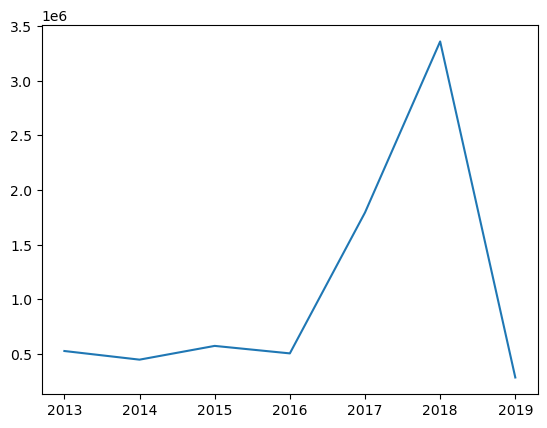

In [11]:
# plot the sum of acres burned per year
plt.plot(ca_fires['ArchiveYear'].unique(), ca_fires['AcresBurned'].groupby(ca_fires['ArchiveYear']).sum())

<BarContainer object of 59 artists>

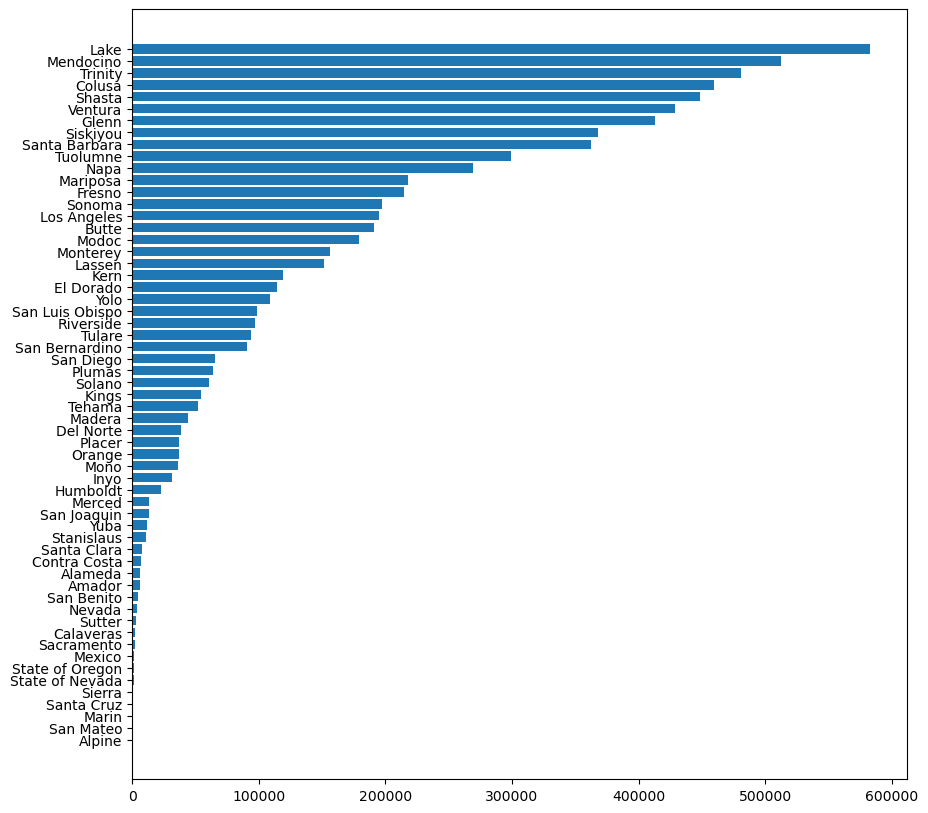

In [12]:
# plot the total number of acres burned by county from 2013-2019
plt.figure(figsize=(10,10))
plt.barh(y=ca_fires['AcresBurned'].groupby(ca_fires['Counties']).sum().sort_values().index, width=ca_fires['AcresBurned'].groupby(ca_fires['Counties']).sum().sort_values())


<BarContainer object of 8 artists>

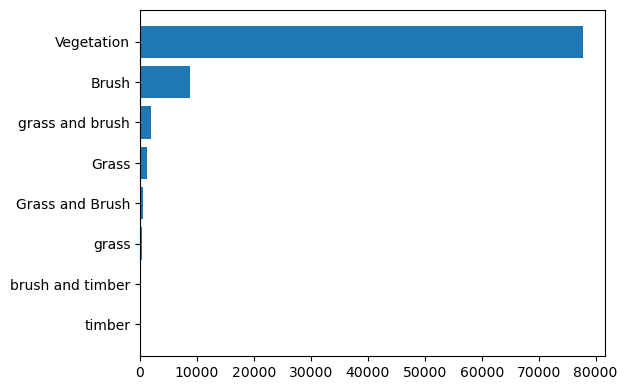

In [13]:
# plot the number of acres burned by primary fuel source 
plt.figure(figsize=(6,4.5))
plt.barh(y=ca_fires['AcresBurned'].groupby(ca_fires['FuelType']).sum().sort_values().index, width=ca_fires['AcresBurned'].groupby(ca_fires['FuelType']).sum().sort_values())

In [14]:
#drop the county feature to eliminate duplicate counts of acres burned
ca_fires1 = ca_fires.drop(['Counties'], axis=1)

#drop duplicate rows
ca_fires1 = ca_fires1.drop_duplicates()
ca_fires1.describe()

,AcresBurned,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Fatalities,Helicopters,Injuries,Latitude,Longitude,PersonnelInvolved,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,WaterTenders,Length
count,1606.000000,28.000000,1609.000000,165.000000,118.000000,185.000000,13.000000,81.000000,109.000000,1609.000000,1609.000000,197.000000,60.000000,158.000000,0.0,23.000000,141.000000,1550
mean,3241.598381,4.071429,2016.612803,11.030303,6.194915,21.264865,10.846154,5.049383,3.605505,37.238964,-108.007602,301.431472,43.250000,222.215190,NaN,342.782609,6.659574,84 days 15:10:27.096774194
std,18670.755103,6.399818,1.841306,13.676321,10.418802,33.740057,22.999443,7.005179,3.953476,136.526838,37.082460,446.623742,120.535335,1569.697717,NaN,646.354108,9.461825,883 days 09:21:33.080503424
min,0.000000,0.000000,2013.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-120.258000,-124.196290,0.000000,0.000000,0.000000,NaN,0.000000,1.000000,-17052 days +00:00:00
25%,35.000000,2.000000,2015.000000,2.000000,1.000000,5.000000,1.000000,1.000000,1.000000,34.154750,-121.741210,55.000000,1.000000,1.000000,NaN,0.000000,2.000000,2 days 00:00:00
50%,97.000000,2.000000,2017.000000,6.000000,2.000000,10.000000,3.000000,2.000000,3.000000,37.085290,-120.452000,150.000000,4.500000,5.000000,NaN,10.000000,4.000000,20 days 00:00:00
75%,400.000000,4.000000,2018.000000,13.000000,5.000000,23.000000,6.000000,5.000000,4.000000,39.100408,-117.460278,342.000000,22.250000,28.750000,NaN,358.000000,6.000000,171 days 00:00:00
max,410203.000000,27.000000,2019.000000,82.000000,76.000000,256.000000,85.000000,29.000000,26.000000,5487.000000,118.908200,3100.000000,783.000000,18804.000000,NaN,2600.000000,79.000000,17901 days 00:00:00


Total acres burned is overstated becuase the total number of acres each fire burned is counted in each county the fire touched. By eliminating the 'County' feature and reducing duplicates, the acres burned per fire is only counted once. 

## Explore target feauture

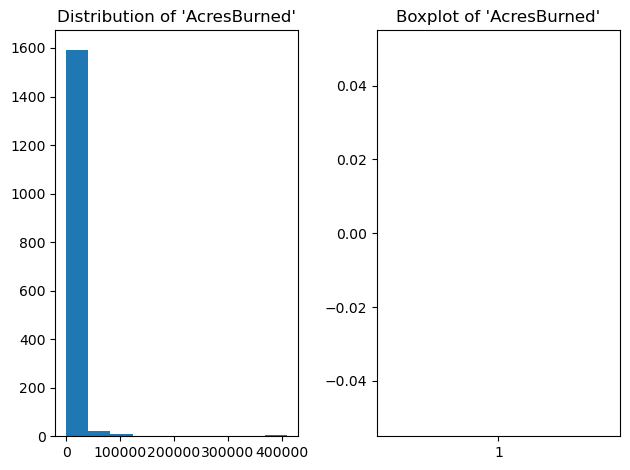

In [15]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(ca_fires['AcresBurned'])
axes[0].set_title("Distribution of 'AcresBurned'")

axes[1].boxplot(ca_fires1['AcresBurned'])
axes[1].set_title("Boxplot of 'AcresBurned'")

fig.tight_layout()

In [16]:
#locate the rows with the incorrect datetime stamp 
ca_fires1[ca_fires1['Started']< pd.to_datetime(1971)]

,AcresBurned,AdminUnit,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,FuelType,...,MajorIncident,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,WaterTenders,Length
1019,12.0,CAL FIRE Madera-Mariposa-Merced Unit,NaN,2017,NaN,NaN,NaN,2018-01-09,NaN,NaN,...,False,Taglio Fire,NaN,1969-12-31,NaN,NaN,NaN,NaN,NaN,17541 days
1261,45.0,Marin County Fire,NaN,2018,NaN,NaN,NaN,2019-01-04,NaN,NaN,...,False,Bridge Fire,NaN,1969-12-31,NaN,NaN,NaN,NaN,NaN,17901 days


In [17]:
#remove incorrect time stamped fires
ca_firesx = ca_fires1[ca_fires1['Started']> pd.to_datetime(1971)]

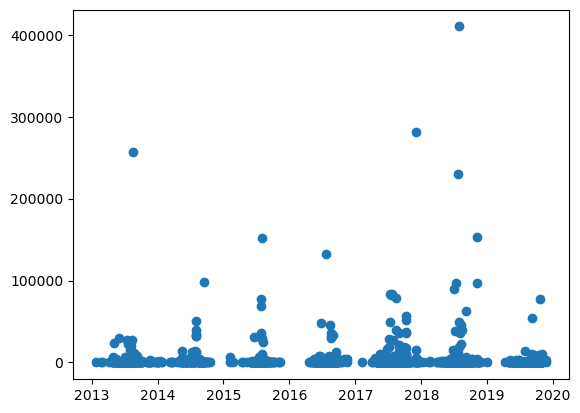

In [18]:
plt.scatter(ca_firesx['Started'] ,ca_firesx['AcresBurned'])

In [19]:
#remove nan values in 'AcresBurned'
ca_fires1['AcresBurned'].isna().sum()
ca_fires1 = ca_fires1.dropna(subset=['AcresBurned'])

In [20]:
ca_fires1['AcresBurned'].describe()

count      1606.000000
mean       3241.598381
std       18670.755103
min           0.000000
25%          35.000000
50%          97.000000
75%         400.000000
max      410203.000000
Name: AcresBurned, dtype: float64

The target feature shows a high standard deviation, but a relatively small mean. The max value is much higher than the third quartile. This supports the observations seen in the distribution plots. Most values of AcresBurned are relatively low with a few high outliers. 

In [21]:
# calculate the upper and lower thresholds for outliers using IQR methodology
upper = np.percentile(ca_fires1['AcresBurned'], 75) + 1.5*stats.iqr(ca_fires1['AcresBurned'])
lower = np.percentile(ca_fires1['AcresBurned'], 25) - 1.5*stats.iqr(ca_fires1['AcresBurned'])

print(upper)
print(lower)

947.5
-512.5


In [22]:
# create a dataframe of outlier values 
outlier1fires = ca_fires1[ca_fires1['AcresBurned']>947.5] 
outlier1fires['AcresBurned'].describe()

count       292.000000
mean      17233.849315
std       41017.514811
min         962.000000
25%        1789.500000
50%        4030.500000
75%       12780.500000
max      410203.000000
Name: AcresBurned, dtype: float64

(array([264.,  15.,   6.,   3.,   0.,   1.,   2.,   0.,   0.,   1.]),
 array([   962. ,  41886.1,  82810.2, 123734.3, 164658.4, 205582.5,
        246506.6, 287430.7, 328354.8, 369278.9, 410203. ]),
 <BarContainer object of 10 artists>)

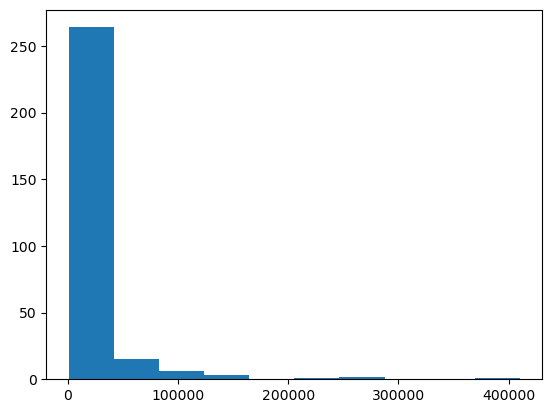

In [23]:
plt.hist([outlier1fires['AcresBurned']])

In [24]:
print("The outlier fires make up", "{:.01%}".format(outlier1fires['AcresBurned'].sum() / ca_fires1['AcresBurned'].sum()), "percent of the total acres burned.")

The outlier fires make up 96.7% percent of the total acres burned.


In [25]:
#calculate the upper and lower thresholds for outlier values within the outlier dataframe
upper = np.percentile(outlier1fires['AcresBurned'], 75) + 1.5*stats.iqr(outlier1fires['AcresBurned'])
lower = np.percentile(outlier1fires['AcresBurned'], 25) - 1.5*stats.iqr(outlier1fires['AcresBurned'])

print(upper)
print(lower)

29267.0
-14697.0


In [26]:
#create a dataframe of the outliers of the outlier data 
outlier2fires = outlier1fires[outlier1fires['AcresBurned']>upper]
outlier2fires['AcresBurned'].describe()

count        48.000000
mean      78281.270833
std       75455.279594
min       29322.000000
25%       36489.750000
50%       48904.500000
75%       83273.250000
max      410203.000000
Name: AcresBurned, dtype: float64

(array([28.,  6.,  7.,  0.,  3.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  1.]),
 array([ 29322.        ,  54714.06666667,  80106.13333333, 105498.2       ,
        130890.26666667, 156282.33333333, 181674.4       , 207066.46666667,
        232458.53333333, 257850.6       , 283242.66666667, 308634.73333333,
        334026.8       , 359418.86666667, 384810.93333333, 410203.        ]),
 <BarContainer object of 15 artists>)

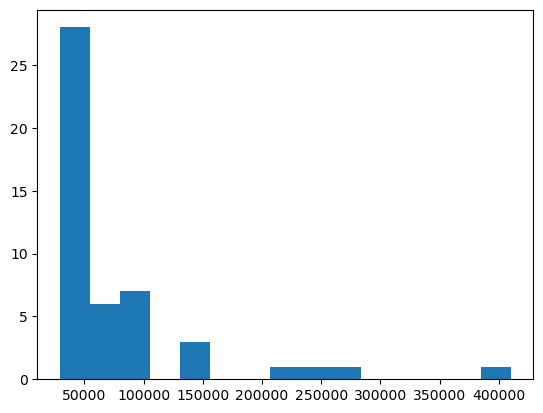

In [27]:
plt.hist([outlier2fires['AcresBurned']], bins=15)

In [28]:
outlier2fires['AcresBurned'].sum()

3757501.0

In [29]:
# calculate the upper and lower thresholds for outliers in the outlier2 dataframe 
upper = np.percentile(outlier2fires['AcresBurned'], 75) + 1.5*stats.iqr(outlier2fires['AcresBurned'])
lower = np.percentile(outlier2fires['AcresBurned'], 25) - 1.5*stats.iqr(outlier2fires['AcresBurned'])

print(upper)
print(lower)

153448.5
-33685.5


In [30]:
# create a dataframe of outliers values from the outlier2 dataframe 
outlier3fires = outlier2fires[outlier2fires['AcresBurned']>upper]
outlier3fires['AcresBurned'].describe()

count         4.000000
mean     294765.250000
std       79862.445544
min      229651.000000
25%      250398.250000
50%      269603.500000
75%      313970.500000
max      410203.000000
Name: AcresBurned, dtype: float64

In [31]:
outlier3fires

,AcresBurned,AdminUnit,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Extinguished,Fatalities,FuelType,...,MajorIncident,Name,PersonnelInvolved,Started,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,WaterTenders,Length
0,257314.0,Stanislaus National Forest/Yosemite National Park,NaN,2013,NaN,NaN,NaN,2013-09-06,NaN,NaN,...,False,Rim Fire,NaN,2013-08-17,NaN,NaN,NaN,NaN,NaN,20 days
616,281893.0,US Forest Service - Los Padres National Forest,NaN,2017,NaN,NaN,NaN,2019-03-14,NaN,NaN,...,True,Thomas Fire,NaN,2017-12-04,280.0,1063.0,NaN,NaN,NaN,465 days
1054,410203.0,USFS Mendocino National Forest,NaN,2018,NaN,NaN,NaN,2019-01-04,1.0,NaN,...,True,Ranch Fire (Mendocino Complex),NaN,2018-07-27,NaN,246.0,NaN,1050.0,NaN,161 days
1058,229651.0,"Unified Command: CAL FIRE Shasta-Trinity Unit,...",NaN,2018,5.0,48.0,11.0,2019-01-04,3.0,NaN,...,True,Carr Fire,456.0,2018-07-23,61.0,1614.0,NaN,NaN,31.0,165 days


In [32]:
print('When the outlier IQR test is performed once we find that these outliers make up',
"{:.01%}".format(outlier1fires['AcresBurned'].sum() / ca_fires1['AcresBurned'].sum()), 'percent of total acres burned.\n')
print('When the outlier IQR test is performed twice we find that these outliers make up',
"{:.01%}".format(outlier2fires['AcresBurned'].sum()/ca_fires1['AcresBurned'].sum()), 'percent of total acres burned.\n')
print('When the outlier IQR test is performed three times we find that these outliers make up',
"{:.01%}".format(outlier3fires['AcresBurned'].sum()/ca_fires1['AcresBurned'].sum()), 'percent of total acres burned.')

When the outlier IQR test is performed once we find that these outliers make up 96.7% percent of total acres burned.

When the outlier IQR test is performed twice we find that these outliers make up 72.2% percent of total acres burned.

When the outlier IQR test is performed three times we find that these outliers make up 22.6% percent of total acres burned.


The majority of recorded fires are insubstantial. The outlier fires may be of greater concern. 

In [33]:
# generate a correlation matrix
ca_fires1.corr()

,AcresBurned,AirTankers,ArchiveYear,CrewsInvolved,Dozers,Engines,Fatalities,Helicopters,Injuries,Latitude,Longitude,MajorIncident,PersonnelInvolved,StructuresDamaged,StructuresDestroyed,StructuresEvacuated,StructuresThreatened,WaterTenders
AcresBurned,1.000000,0.087599,-0.015216,0.076175,0.400498,0.227666,0.119278,0.033276,0.010991,-0.003876,-0.000822,0.132696,0.244616,0.401915,0.310300,NaN,0.218086,0.287289
AirTankers,0.087599,1.000000,-0.422612,0.602916,0.779673,0.430673,NaN,0.824106,0.799003,-0.018584,-0.022760,0.135550,0.434371,0.887242,0.572404,NaN,-0.076033,0.802913
ArchiveYear,-0.015216,-0.422612,1.000000,-0.225844,-0.136430,-0.075516,0.072729,-0.371893,-0.315559,0.014073,-0.308431,-0.131857,-0.114759,0.120358,0.087558,NaN,-0.053928,-0.179046
CrewsInvolved,0.076175,0.602916,-0.225844,1.000000,0.639358,0.743474,0.676507,0.685521,0.479059,-0.045201,0.015377,0.052372,0.803128,-0.139726,-0.021067,NaN,0.463889,0.723351
Dozers,0.400498,0.779673,-0.136430,0.639358,1.000000,0.686336,-0.498782,0.767998,0.230624,0.081399,-0.088961,0.093796,0.674363,0.316438,-0.025681,NaN,0.385203,0.943959
Engines,0.227666,0.430673,-0.075516,0.743474,0.686336,1.000000,0.995691,0.495020,0.652464,-0.018484,-0.017472,0.056758,0.922547,-0.048480,0.101563,NaN,0.442310,0.753471
Fatalities,0.119278,NaN,0.072729,0.676507,-0.498782,0.995691,1.000000,0.490992,0.079313,0.243447,-0.089816,NaN,0.930077,0.325390,0.988997,NaN,NaN,-0.301116
Helicopters,0.033276,0.824106,-0.371893,0.685521,0.767998,0.495020,0.490992,1.000000,0.399644,-0.021528,0.009612,0.065031,0.512676,-0.354773,-0.096406,NaN,0.575548,0.710144
Injuries,0.010991,0.799003,-0.315559,0.479059,0.230624,0.652464,0.079313,0.399644,1.000000,-0.212679,0.206175,0.039257,0.584741,-0.179371,-0.044790,NaN,-0.152073,0.291371
Latitude,-0.003876,-0.018584,0.014073,-0.045201,0.081399,-0.018484,0.243447,-0.021528,-0.212679,1.000000,-0.078462,-0.011639,-0.059377,0.068625,0.054383,NaN,0.182560,0.006932


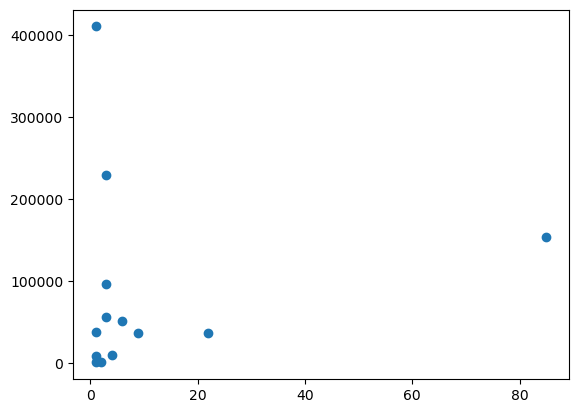

In [34]:
#plot AcresBurned against Fatalities 
plt.scatter(ca_fires1['Fatalities'], ca_fires1['AcresBurned'])

Suprisingly, there is a weak correlation between acresburned and fatalities. There is a strong corrleation between the number of fatalities and the numberof personnel and structures destroyed. Acres burned may be a stronger indicator of ecological damage than direct danger to humans. 

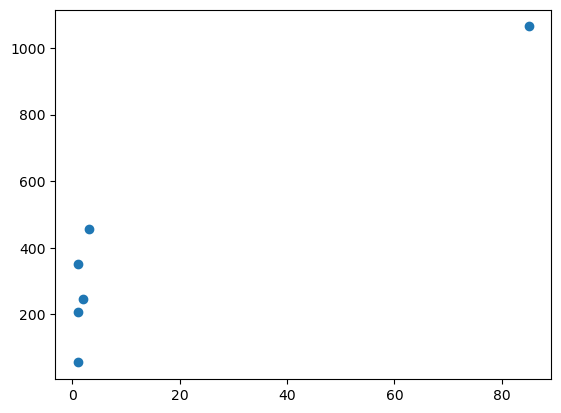

In [35]:
# plot fatalities against the number of personnel involved to examine the correlation
plt.scatter(ca_fires1['Fatalities'], ca_fires1['PersonnelInvolved'])

### Examine Fatalities feature 

In [38]:
# remove all fires with zero fatalites to analyze the distribution 
ca_fires1['Fatalities'].isna().sum()
ca_fatalities = ca_fires1.dropna(subset=['Fatalities'])

<Axes: >

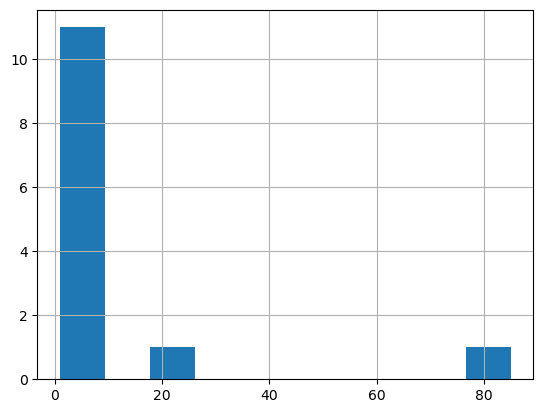

In [39]:
#check the distribution of fatalities 
ca_fatalities['Fatalities'].hist()

The majority of fatalities occur across very few fires and the majority of acres burned also occurs across very few fires. 

## Analyze Target Feature 

In [40]:
# group acres burned by the day the fire started to use in time series analysis 
daily_fires = ca_fires1.groupby(ca_fires1['Started'])['AcresBurned'].sum().reset_index()

#remove the first value which is incorrectly dated 
daily_fires = daily_fires[1:]

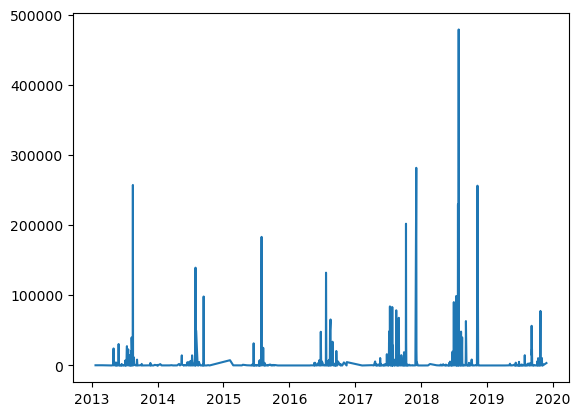

In [41]:
# plot Acres Burned when grouped by day started 
plt.plot(daily_fires['Started'], daily_fires['AcresBurned'])

In [42]:
daily_fires1 = daily_fires[daily_fires['AcresBurned']>0]

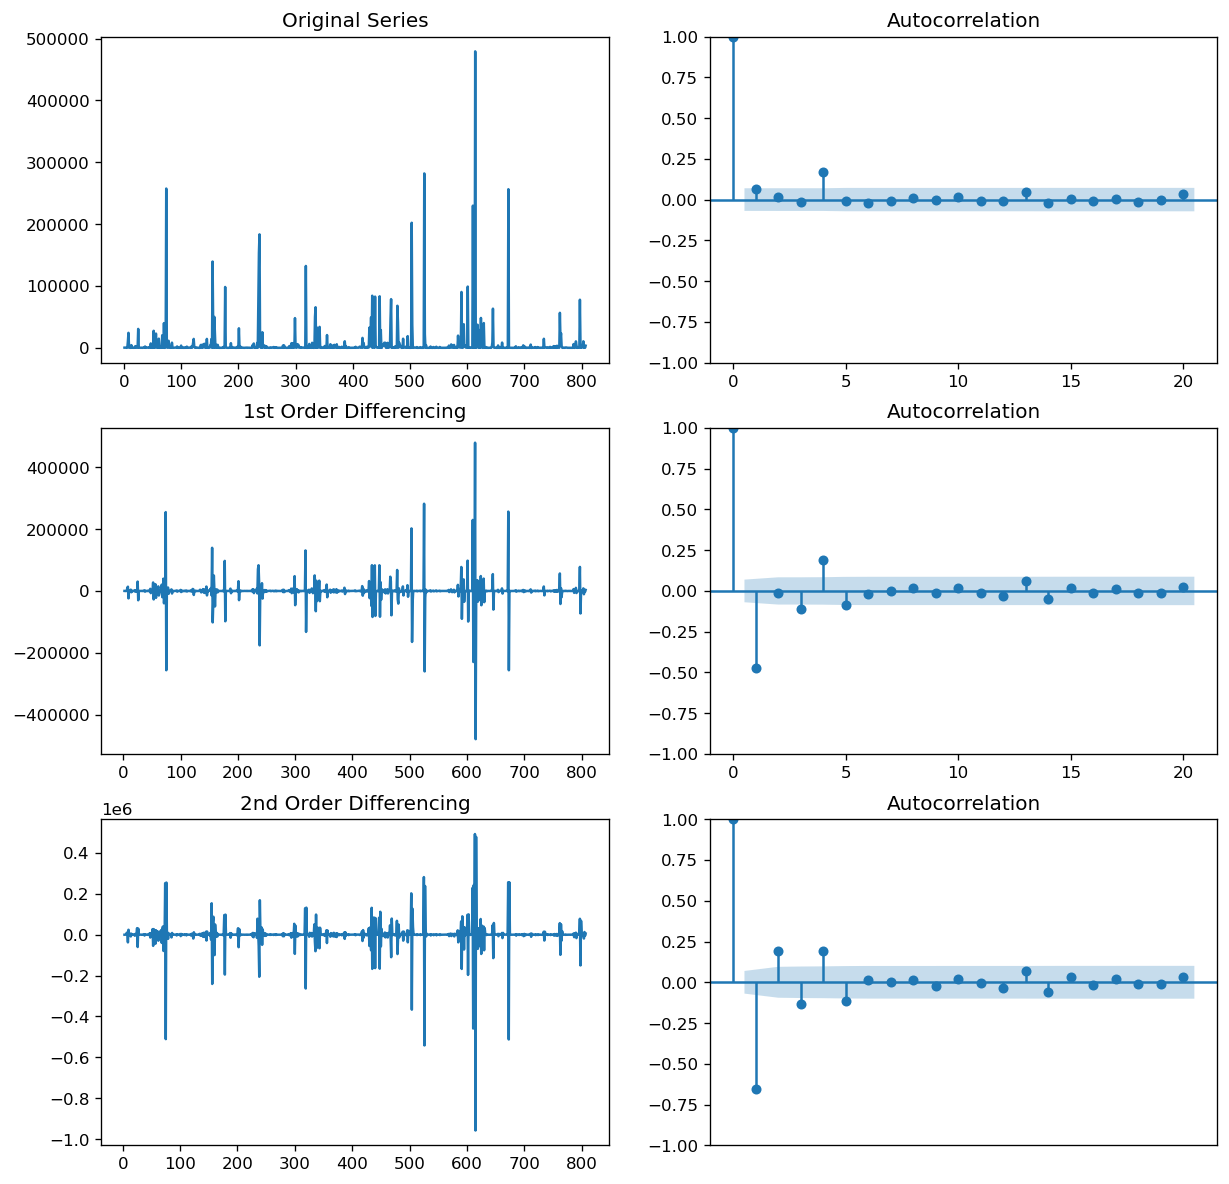

In [43]:
# Create a chart to check for stationality and view ACF  

plt.rcParams.update({'figure.figsize':(12,12), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(daily_fires1['AcresBurned']); axes[0, 0].set_title('Original Series')
plot_acf(daily_fires1['AcresBurned'], ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(daily_fires1['AcresBurned'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(daily_fires1['AcresBurned'].diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(daily_fires1['AcresBurned'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(daily_fires1['AcresBurned'].diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.xticks([])
plt.show()

In [44]:
# Utilize adf to test for stationarity 
result = adfuller(daily_fires1['AcresBurned'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.691825
p-value: 0.000000


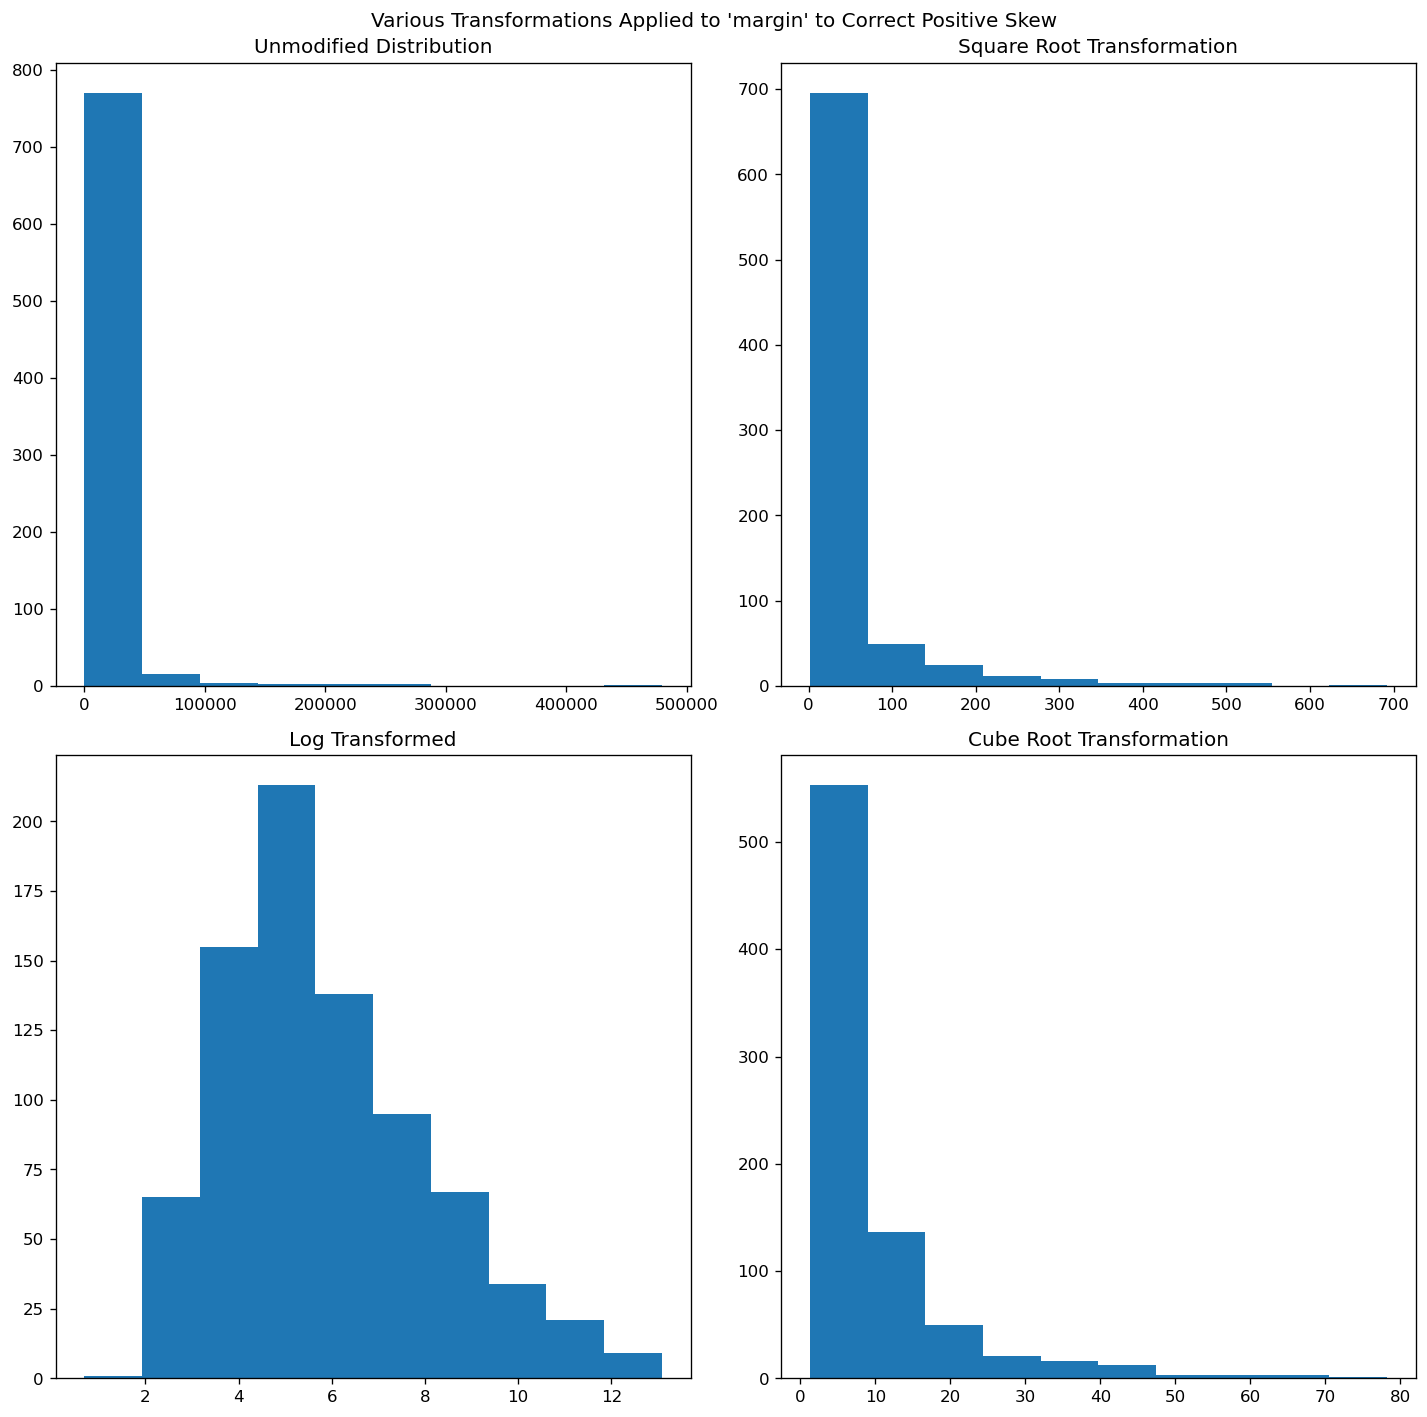

In [45]:
# Compare the effectiveness of various transformations for correcting the positive skew 
fig, axs = plt.subplots(2, 2)
fig.suptitle("Various Transformations Applied to 'margin' to Correct Positive Skew")
axs[0, 0].hist(daily_fires1['AcresBurned'])
axs[0, 0].set_title("Unmodified Distribution")
axs[1, 0].hist(np.log(daily_fires1['AcresBurned']))
axs[1, 0].set_title("Log Transformed")
axs[0, 1].hist(np.sqrt(daily_fires1['AcresBurned']))
axs[0, 1].set_title("Square Root Transformation")
axs[1, 1].hist(np.cbrt(daily_fires1['AcresBurned']))
axs[1, 1].set_title("Cube Root Transformation")
fig.tight_layout()

The log transformation is the most effective at remediating the positive skew 

In [46]:
# log transform the daily fires data 
daily_fires2 = np.log(daily_fires1['AcresBurned'])

In [47]:
# Utilize adf to test for stationarity 
result = adfuller(daily_fires2.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.851869
p-value: 0.000000


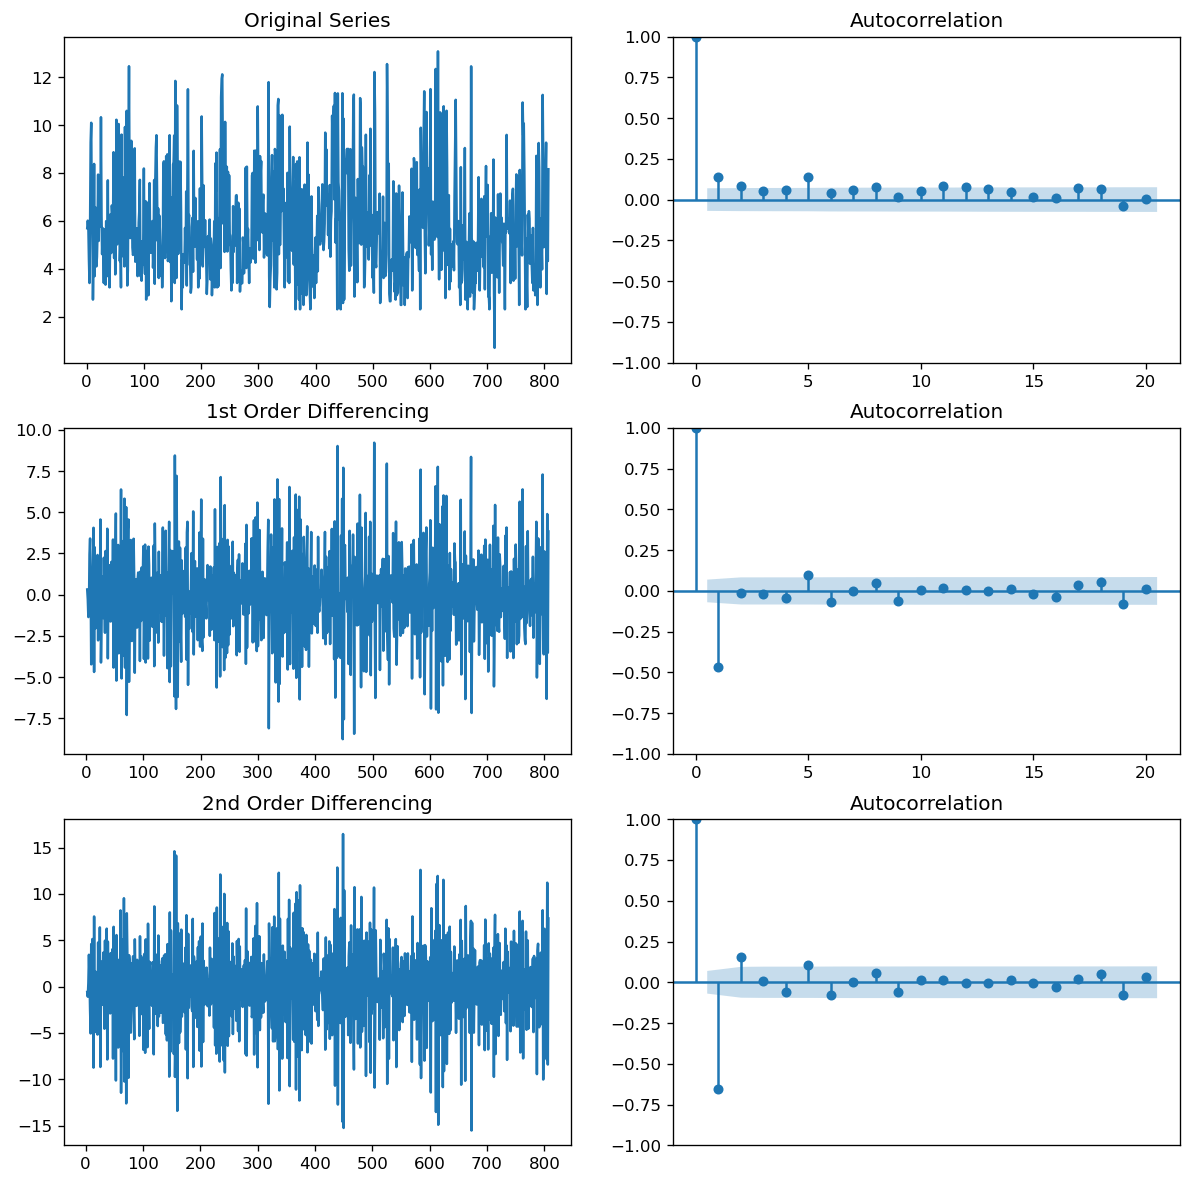

In [48]:
# Create a chart to check for stationality and view ACF of the log transformed feature  

plt.rcParams.update({'figure.figsize':(12,12), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(daily_fires2); axes[0, 0].set_title('Original Series')
plot_acf(daily_fires2, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(daily_fires2.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(daily_fires2.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(daily_fires2.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(daily_fires2.diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.xticks([])
plt.show()

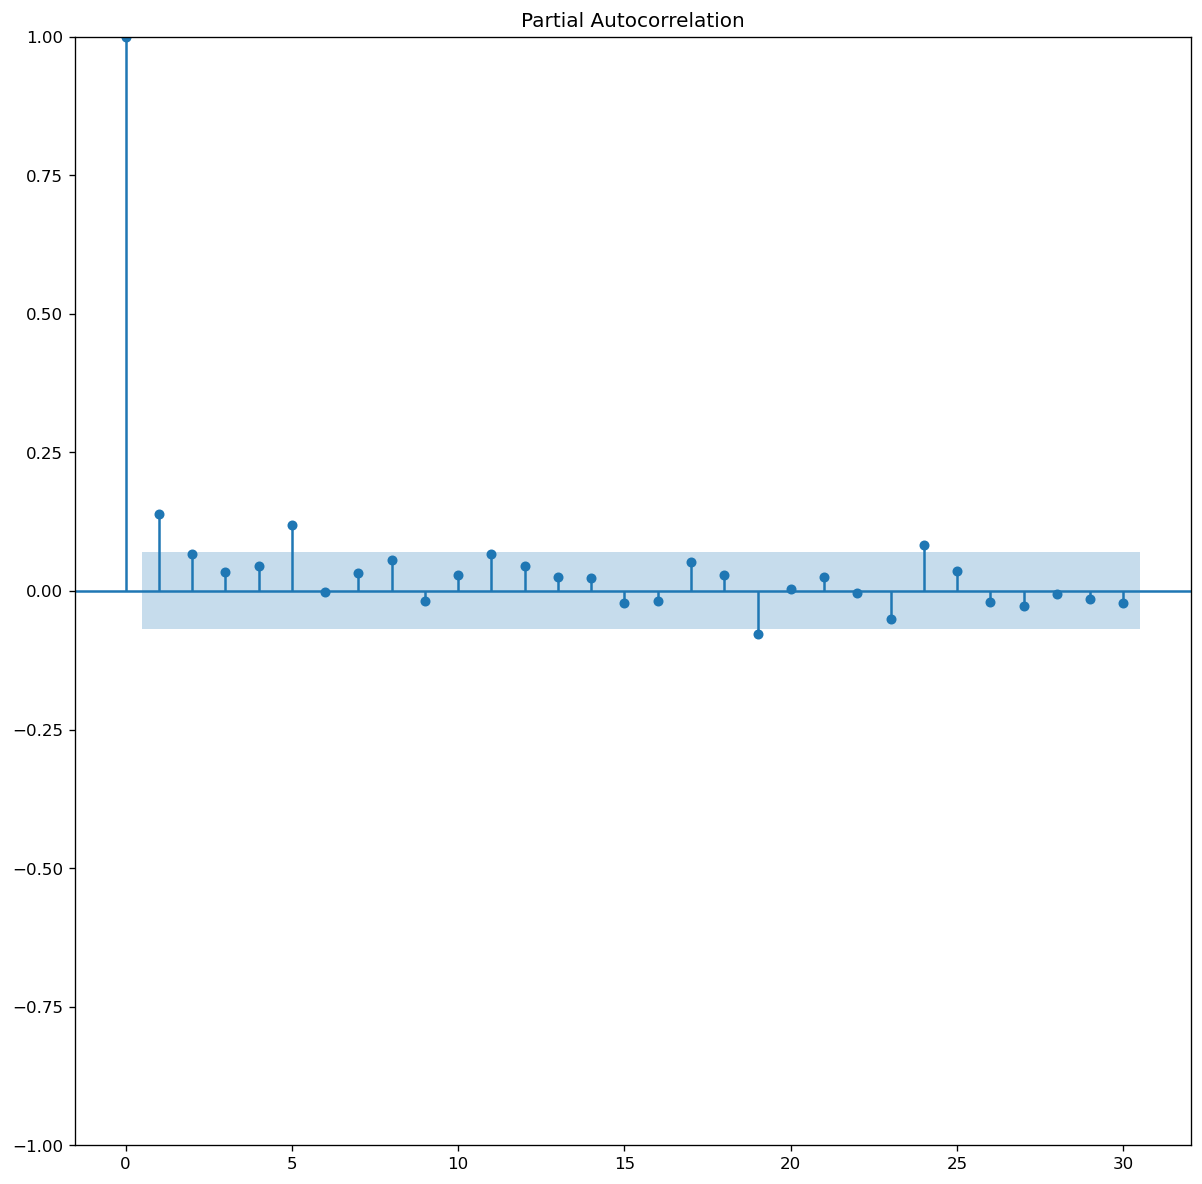

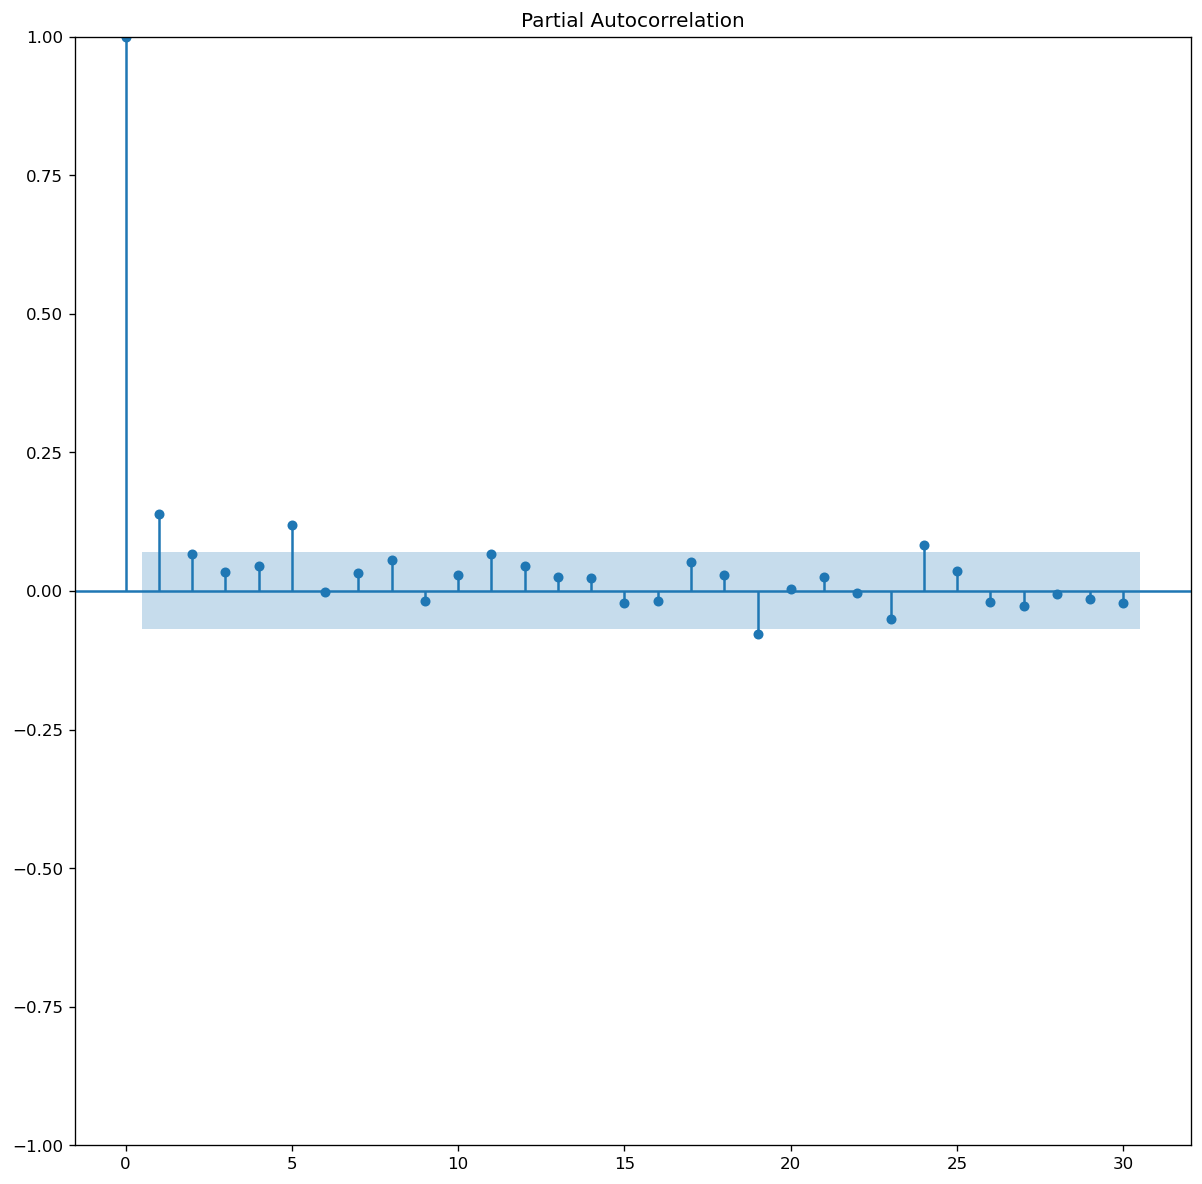

In [49]:
# view the pacf plot 
plot_pacf(daily_fires2, method='ywm')

# Modeling

## Model 1: Sarima Modeling of Acres Burned Aggregated by Day Started

In [50]:
# find recommended order for Sarima hyperparameters 
pm.auto_arima(daily_fires2, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [129]:
#split a train and test group along time index
X = daily_fires2.reset_index(drop=True)
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [130]:
#fit a model using recommended orders 
model = SARIMAX(train,exog=None, order=(1, 0, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

# generate predictions along test dataset index
yhat = model_fit.predict(start=len(train), end=len(daily_fires2)-1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33254D+00    |proj g|=  1.04062D-01

At iterate    5    f=  2.29724D+00    |proj g|=  3.89123D-03


 This problem is unconstrained.



At iterate   10    f=  2.29600D+00    |proj g|=  4.65725D-03

At iterate   15    f=  2.29597D+00    |proj g|=  1.55480D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   1.555D-06   2.296D+00
  F =   2.2959740546638274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [131]:
# print model summary statistics 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         AcresBurned   No. Observations:                  638
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood               -1464.831
Date:                             Sun, 21 Apr 2024   AIC                           2939.663
Time:                                     19:01:07   BIC                           2961.860
Sample:                                          0   HQIC                          2948.287
                                             - 638                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8828      0.062     14.212      0.000       0.761       1.005
ma.L1         -0.7910      0.080     -9.943      0.000      -0.947      -0.635
ar.S.L12      -0.6759      0.039    -17.431      0.000      -0.752      -0.600
ar.S.L24      -0.3013      0.040     -7.594      0.000      -0.379      -0.224
sigma2         6.2503      0.350     17.883      0.000       5.565       6.935
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 9.56
Prob(Q):                              0.83   Prob(JB):                         0.01
Heteroskedasticity (H):               1.32   Skew:                             0.30
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

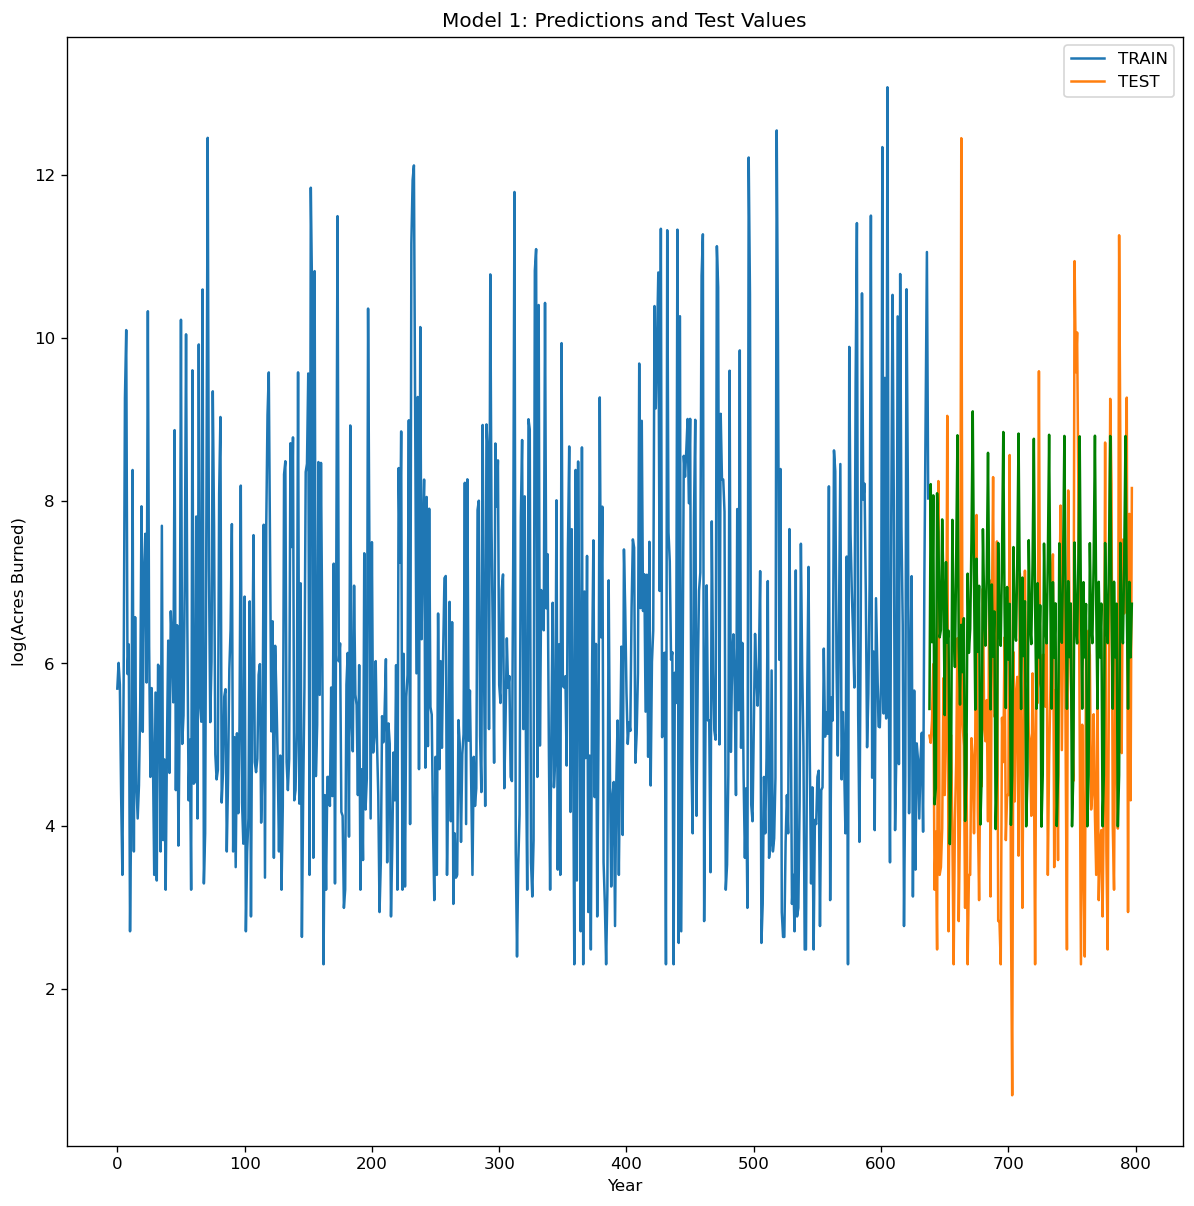

In [132]:
# plot predicted values against actual values 
plt.title('Model 1: Predictions and Test Values')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(yhat.index, yhat, color='green')

In [59]:
# calculate rmse 
rmse = sqrt(mean_squared_error(test, yhat))
print('Test RMSE:', rmse)

#calculate relative rmse
print('Relative RMSE:',rmse / (max(daily_fires2) - min(daily_fires2)))

Test RMSE: 2.4308942228765473
Relative RMSE: 0.19624715980674048


In [56]:
# build model with full dataset 
model = SARIMAX(daily_fires2,exog=None, order=(1, 0, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32280D+00    |proj g|=  1.04836D-01


/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  2.28856D+00    |proj g|=  4.60663D-03

At iterate   10    f=  2.28575D+00    |proj g|=  1.00202D-02

At iterate   15    f=  2.28566D+00    |proj g|=  1.59992D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.883D-06   2.286D+00
  F =   2.2856559475819993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [57]:
# generate predictions for 365 values beyond dataset values 
predictions = model_fit.predict(start=len(daily_fires2), end=len(daily_fires2)+365)

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


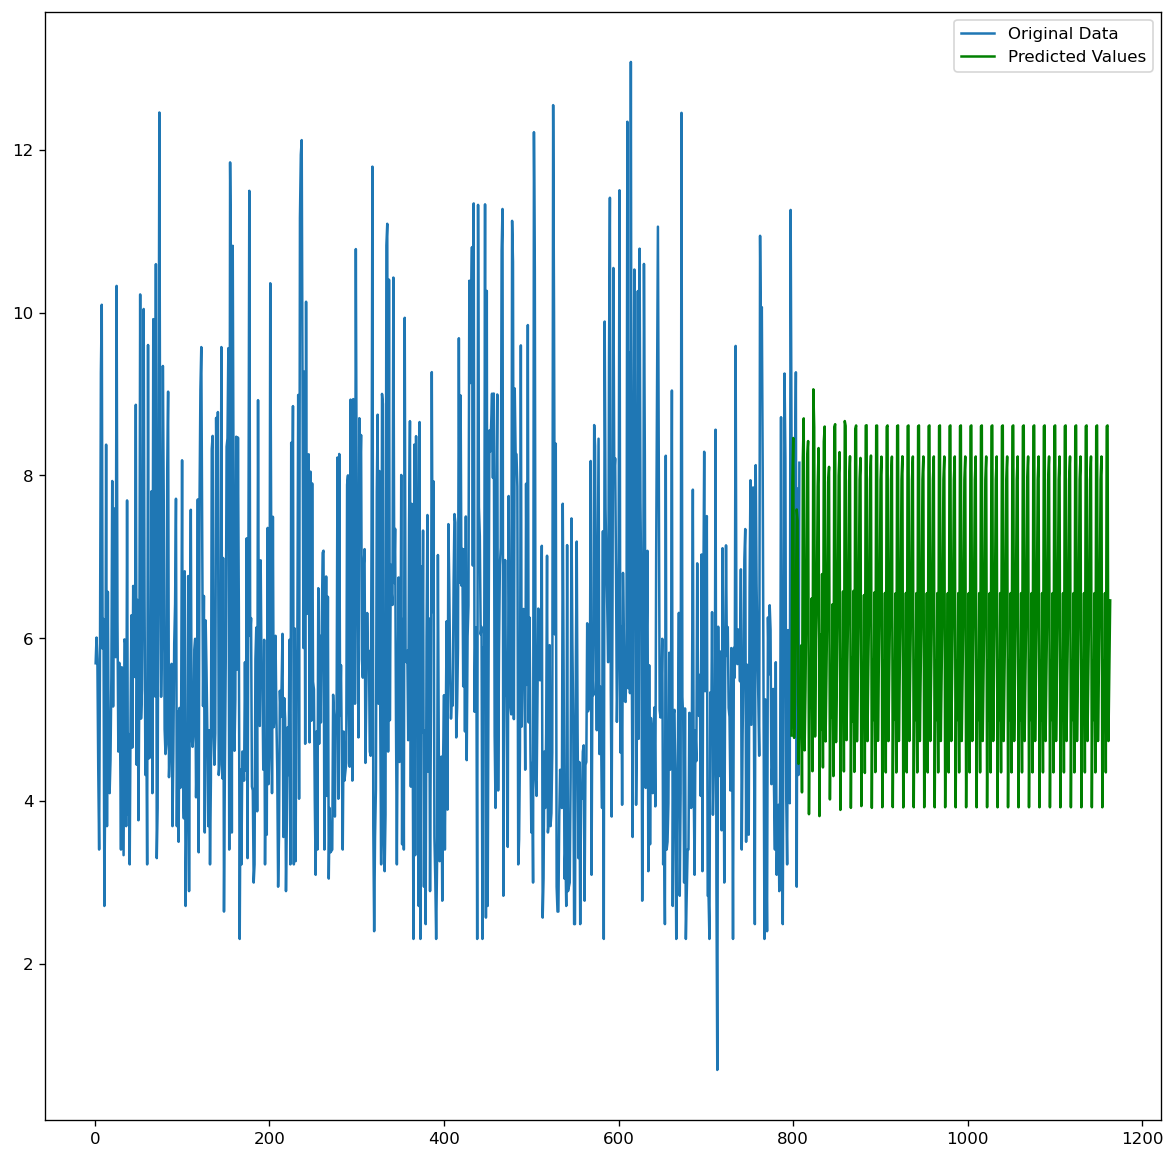

In [65]:
plt.plot(daily_fires2,label='Original Data')
plt.plot(predictions.index, predictions, color='green', label='Predicted Values')
plt.legend()

## Impute missing dates with a value of .01

In [66]:
# set date of fire as the index 
daily_fires3 = daily_fires1.set_index('Started')

In [67]:
# generate a list of the dates with no acreage
new_axis = pd.date_range(daily_fires3.index.min(), daily_fires3.index.max())
missing_dates = list(set(new_axis.difference(pd.to_datetime(daily_fires3.index))))

#set the data type to datetime 
missing_dates = pd.to_datetime(missing_dates).date

In [68]:
# impute 0.01 for all missing dates so that mathematical transformations can be applied to the data 
values = [0.01 for x in missing_dates]

In [69]:
#convert the list of missing dates into a dataframe 
missing = pd.DataFrame(values, index=missing_dates, columns=['AcresBurned'])

In [70]:
# concatenate the original dataframe and the missing dates 
full_fires = pd.concat([missing, daily_fires3])
full_fires = full_fires.sort_index()
full_fires.head()

,AcresBurned
2013-01-22,296.00
2013-01-23,0.01
2013-01-24,0.01
2013-01-25,0.01
2013-01-26,0.01


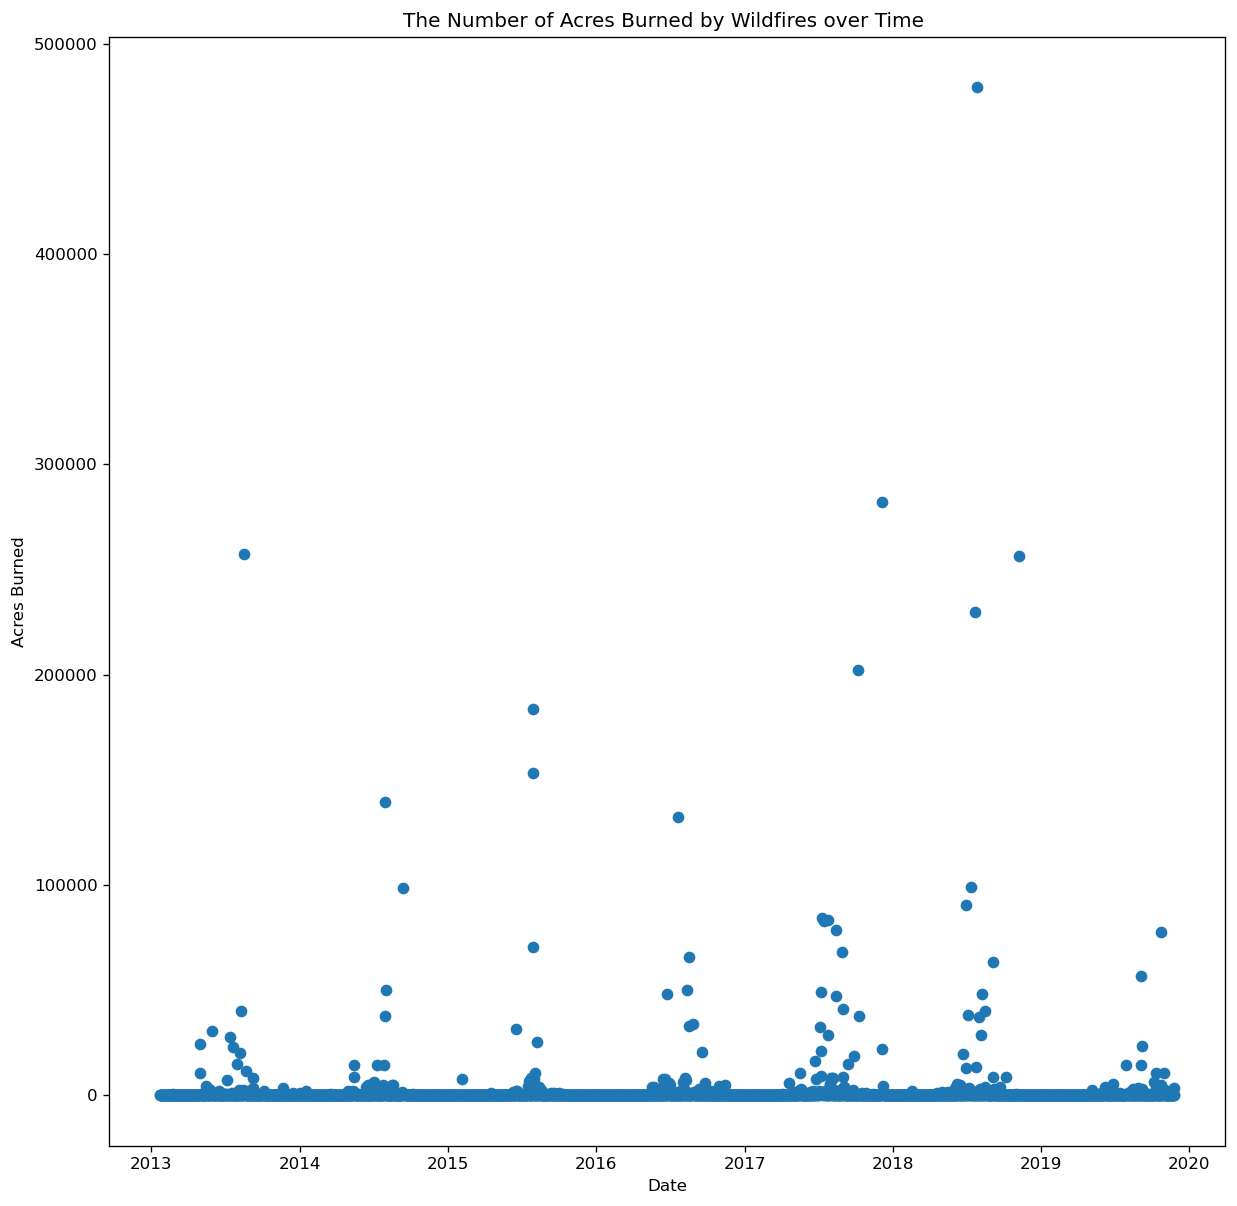

In [142]:
# plot the data points with acreage burned as individual days 
plt.title('The Number of Acres Burned by Wildfires over Time ')
plt.ylabel('Acres Burned')
plt.xlabel('Date')
plt.scatter(full_fires.index, full_fires['AcresBurned'])

array([[<Axes: title={'center': 'AcresBurned'}>]], dtype=object)

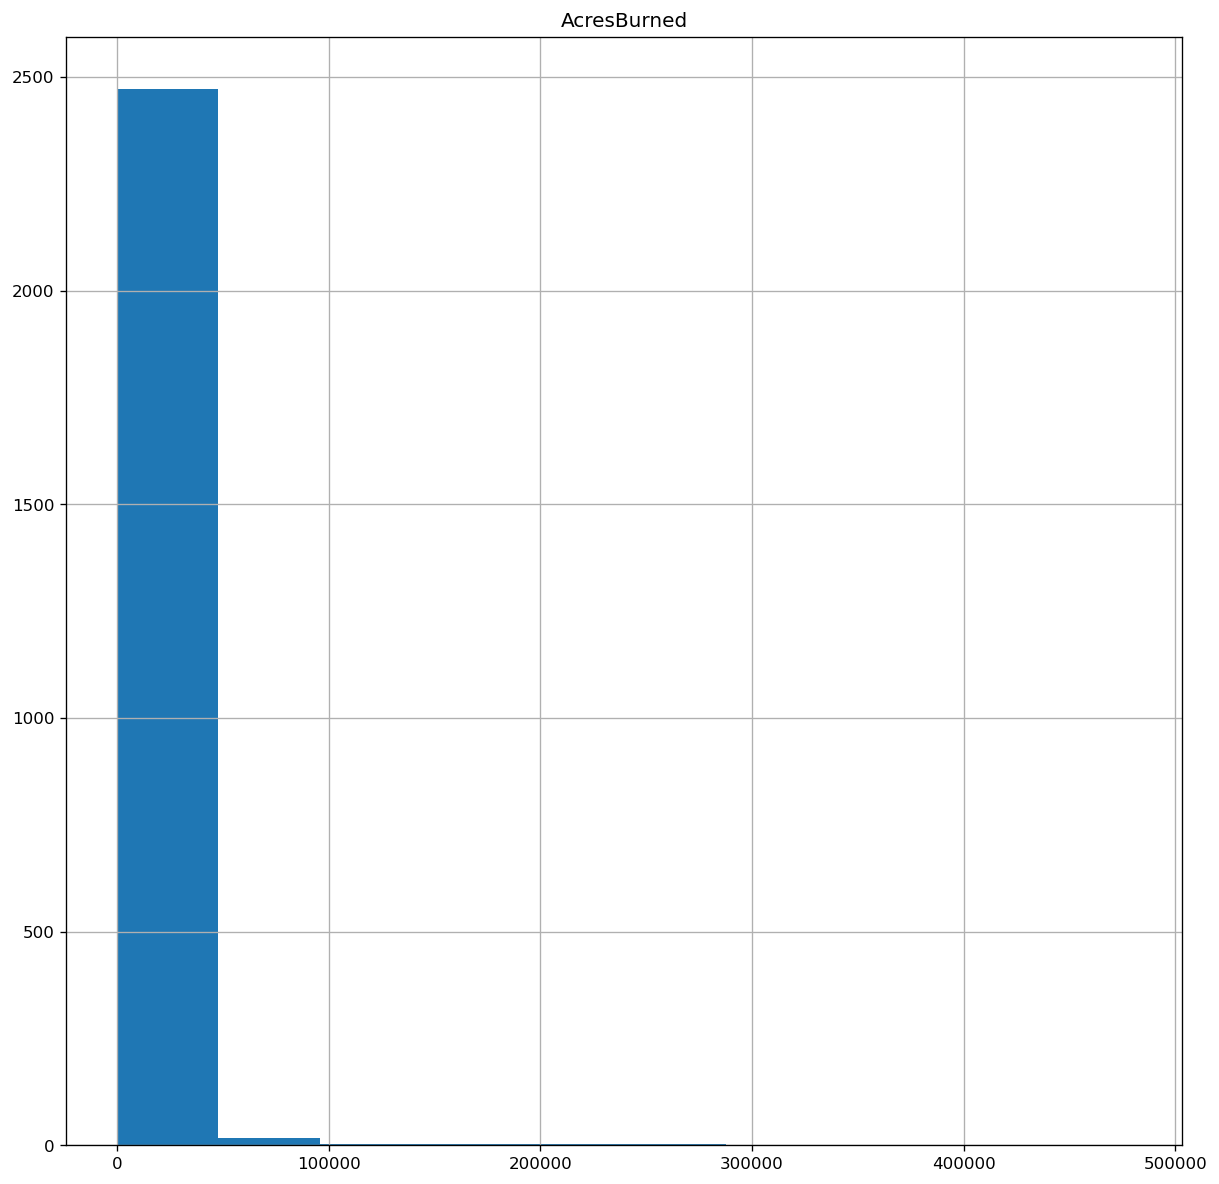

In [72]:
# view the distribution of the target feature 
full_fires.hist()

<Axes: >

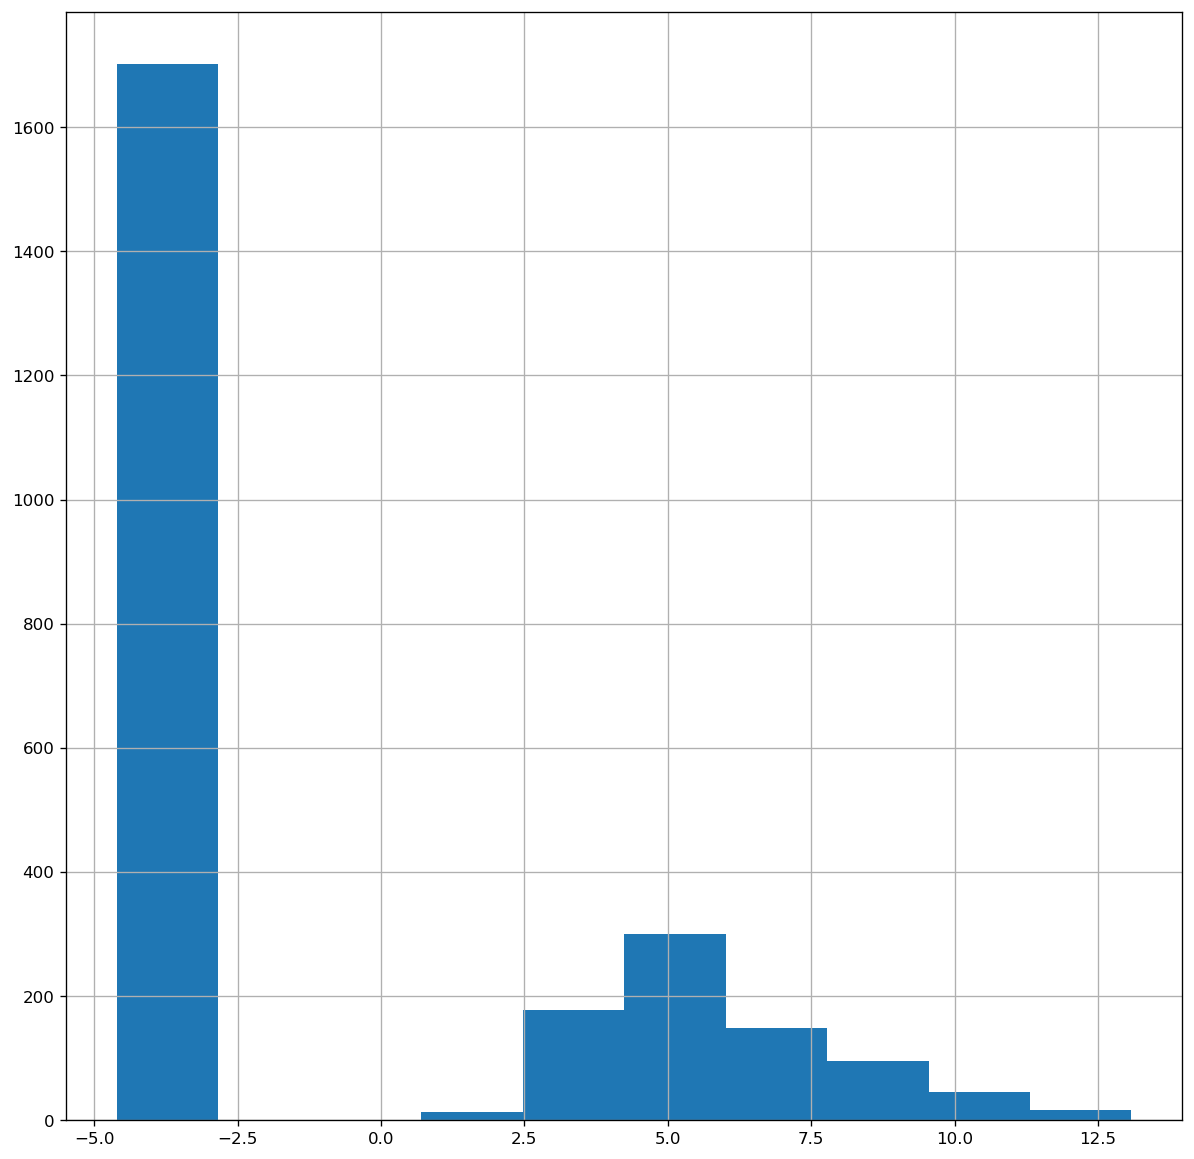

In [73]:
# take the log of the target feature to reduce positive skew 
full_fires_log = np.log(full_fires['AcresBurned'])
full_fires_log.hist()

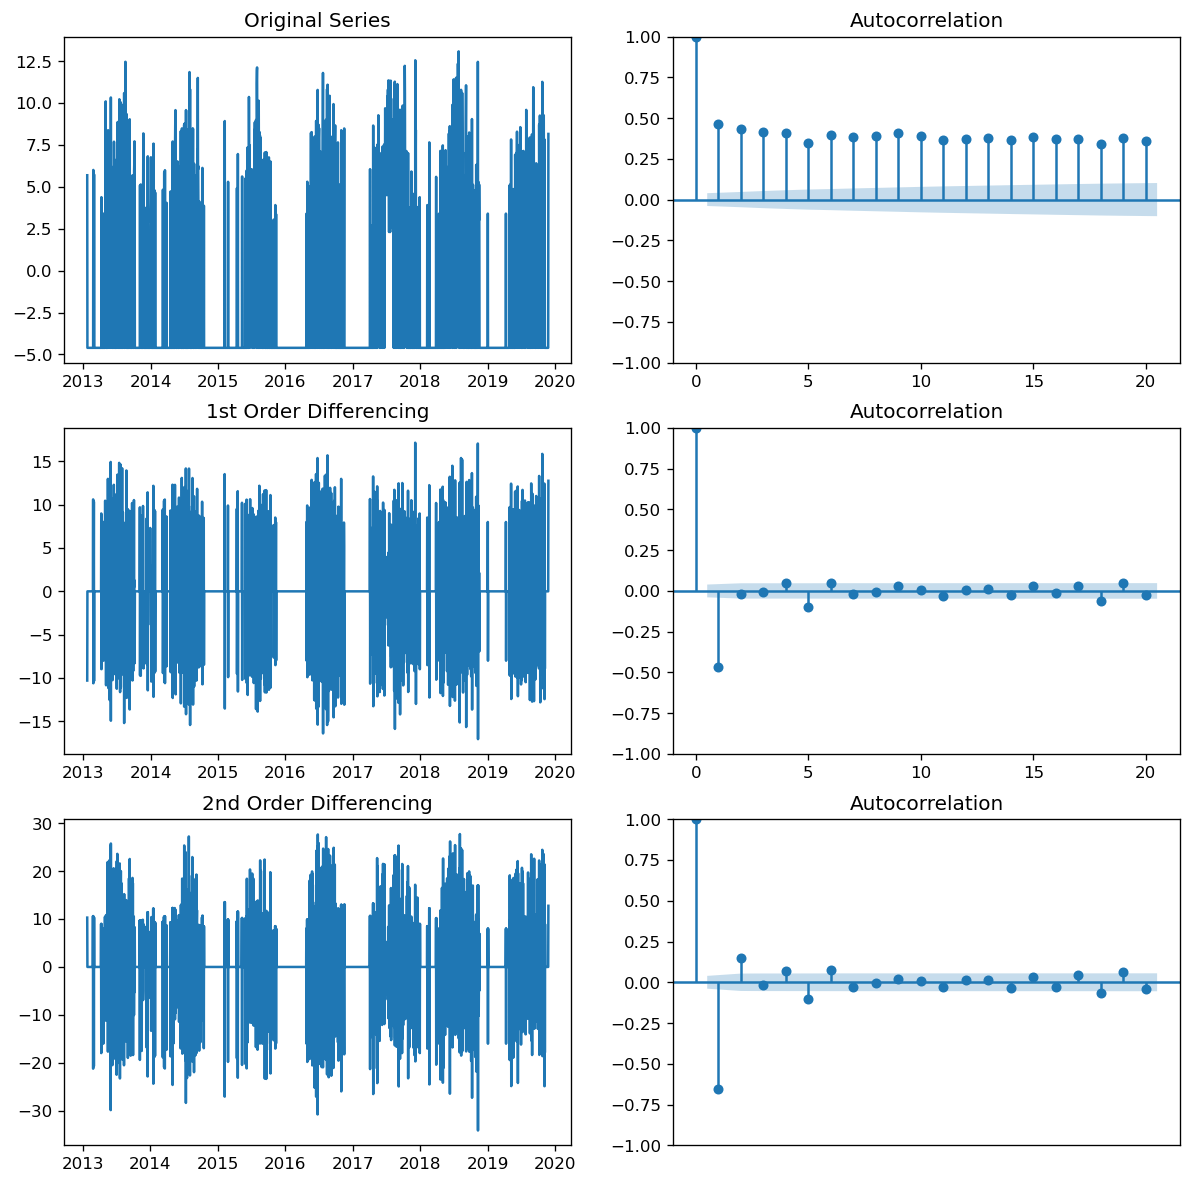

In [74]:
# Create a chart to check for stationality and view ACF  

plt.rcParams.update({'figure.figsize':(12,12), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(full_fires_log); axes[0, 0].set_title('Original Series')
plot_acf(full_fires_log, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(full_fires_log.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(full_fires_log.diff().dropna(), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(full_fires_log.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(full_fires_log.diff().diff().dropna(), ax=axes[2, 1], lags=20)

plt.xticks([])
plt.show()

## Model 2: Sarima model with Manually Selected Orders 

In [75]:
# create a train / test split along the time axis 
X = full_fires_log
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [76]:
model = SARIMAX(train,exog=None, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

yhat = model_fit.predict(start=len(train), end=len(full_fires_log)-1)

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99048D+00    |proj g|=  7.05462D-02

At iterate    5    f=  2.80653D+00    |proj g|=  2.14083D-02

At iterate   10    f=  2.79738D+00    |proj g|=  1.82409D-03

At iterate   15    f=  2.79664D+00    |proj g|=  3.35175D-03

At iterate   20    f=  2.79660D+00    |proj g|=  9.74093D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.743D-06   2.797D+00
  F =   2.7965975307990441     

CONVERG

In [77]:
# view model summary statistics
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        AcresBurned   No. Observations:                 1999
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -5590.398
Date:                            Wed, 17 Apr 2024   AIC                          11188.797
Time:                                    13:54:39   BIC                          11211.172
Sample:                                01-22-2013   HQIC                         11197.016
                                     - 07-13-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8873      0.009   -101.307      0.000      -0.905      -0.870
ar.S.L12      -0.0177      0.019     -0.950      0.342      -0.054       0.019
ma.S.L12      -0.9928      0.012    -81.237      0.000      -1.017      -0.969
sigma2        15.8888      0.454     34.975      0.000      14.998      16.779
===================================================================================
Ljung-Box (L1) (Q):                  13.65   Jarque-Bera (JB):                99.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

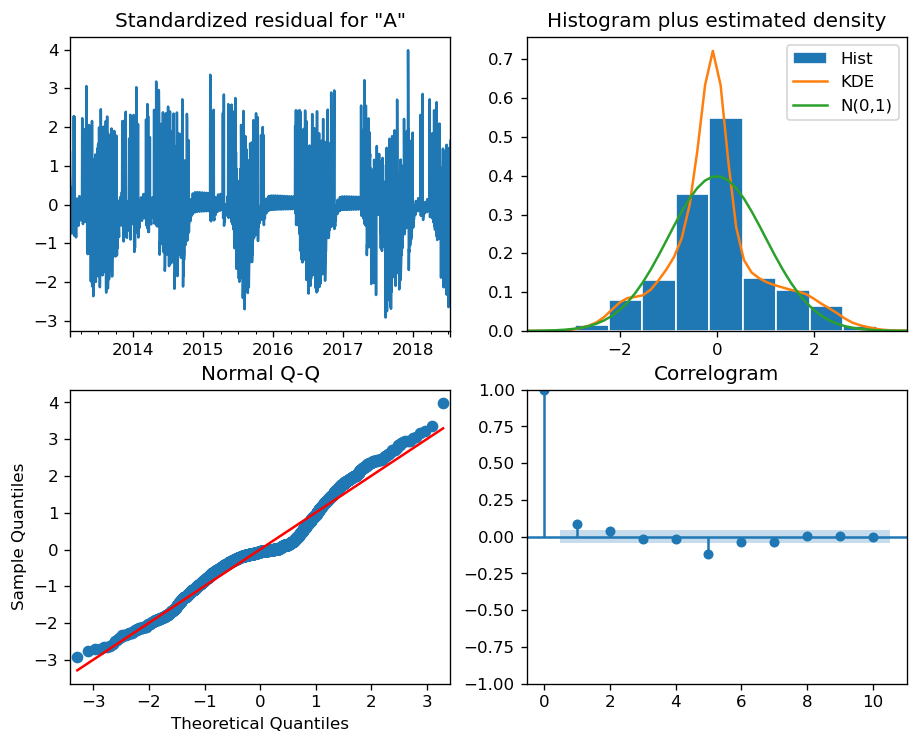

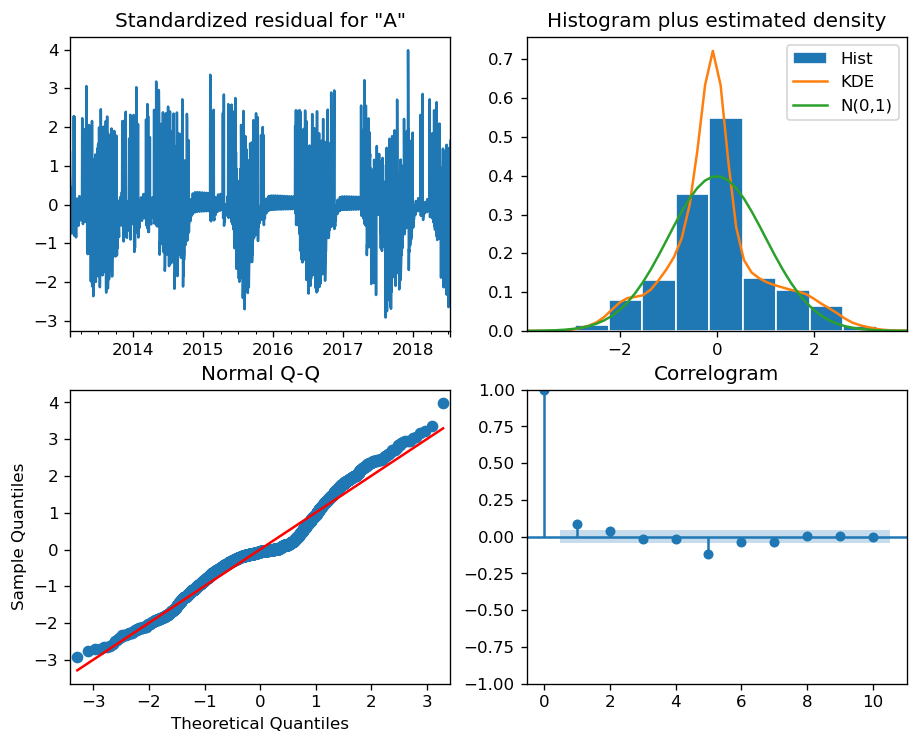

In [78]:
model_fit.plot_diagnostics(figsize=(9,7))

In [79]:
# Calculate the RMSE of the predicted results 
rmse = sqrt(mean_squared_error(test, yhat))
print('Test RMSE:', rmse)

#calculate relative rmse
print('Relative RMSE:',rmse / (max(full_fires_log) - min(full_fires_log)))

Test RMSE: 9.584618242510018
Relative RMSE: 0.5419564415402243


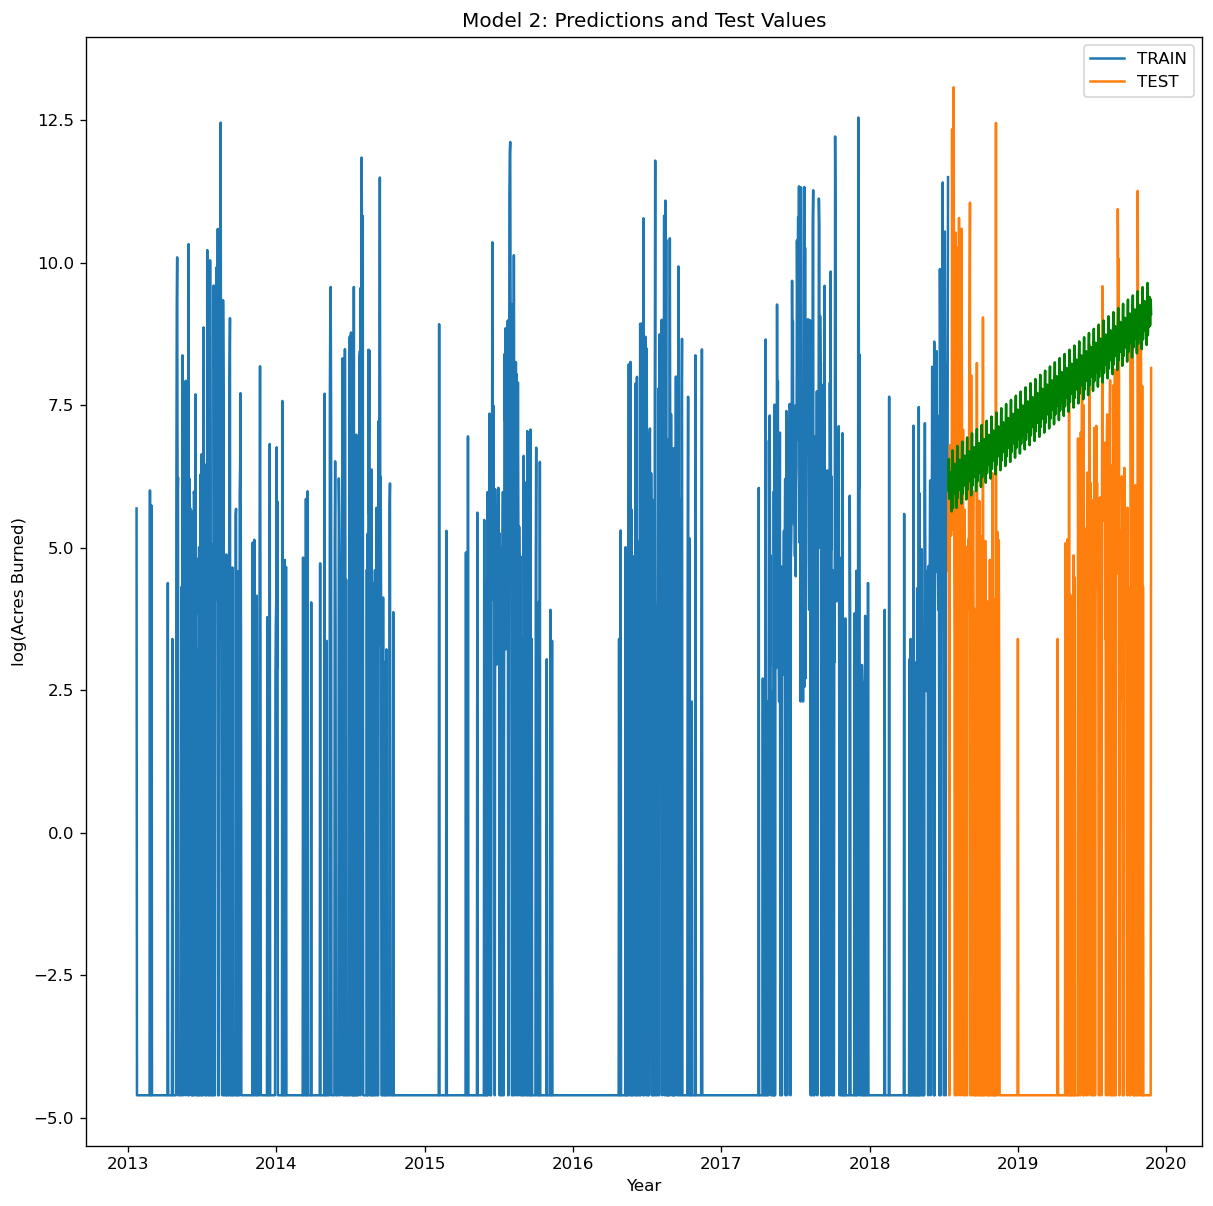

In [90]:
# plot predicted values against test data set 
plt.title('Model 2: Predictions and Test Values')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(yhat.index, yhat, color='green')

In [81]:
# build a model using full dataset 
model = SARIMAX(full_fires_log,exog=None, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

model_fit = model.fit()

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00850D+00    |proj g|=  7.70269D-02

At iterate    5    f=  2.82013D+00    |proj g|=  1.35249D-02

At iterate   10    f=  2.81252D+00    |proj g|=  7.28805D-03

At iterate   15    f=  2.81097D+00    |proj g|=  2.06030D-03

At iterate   20    f=  2.81085D+00    |proj g|=  2.95043D-04

At iterate   25    f=  2.81084D+00    |proj g|=  1.13811D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

In [82]:
predictions = model_fit.predict(start=len(full_fires_log), end=len(full_fires_log)+1095)

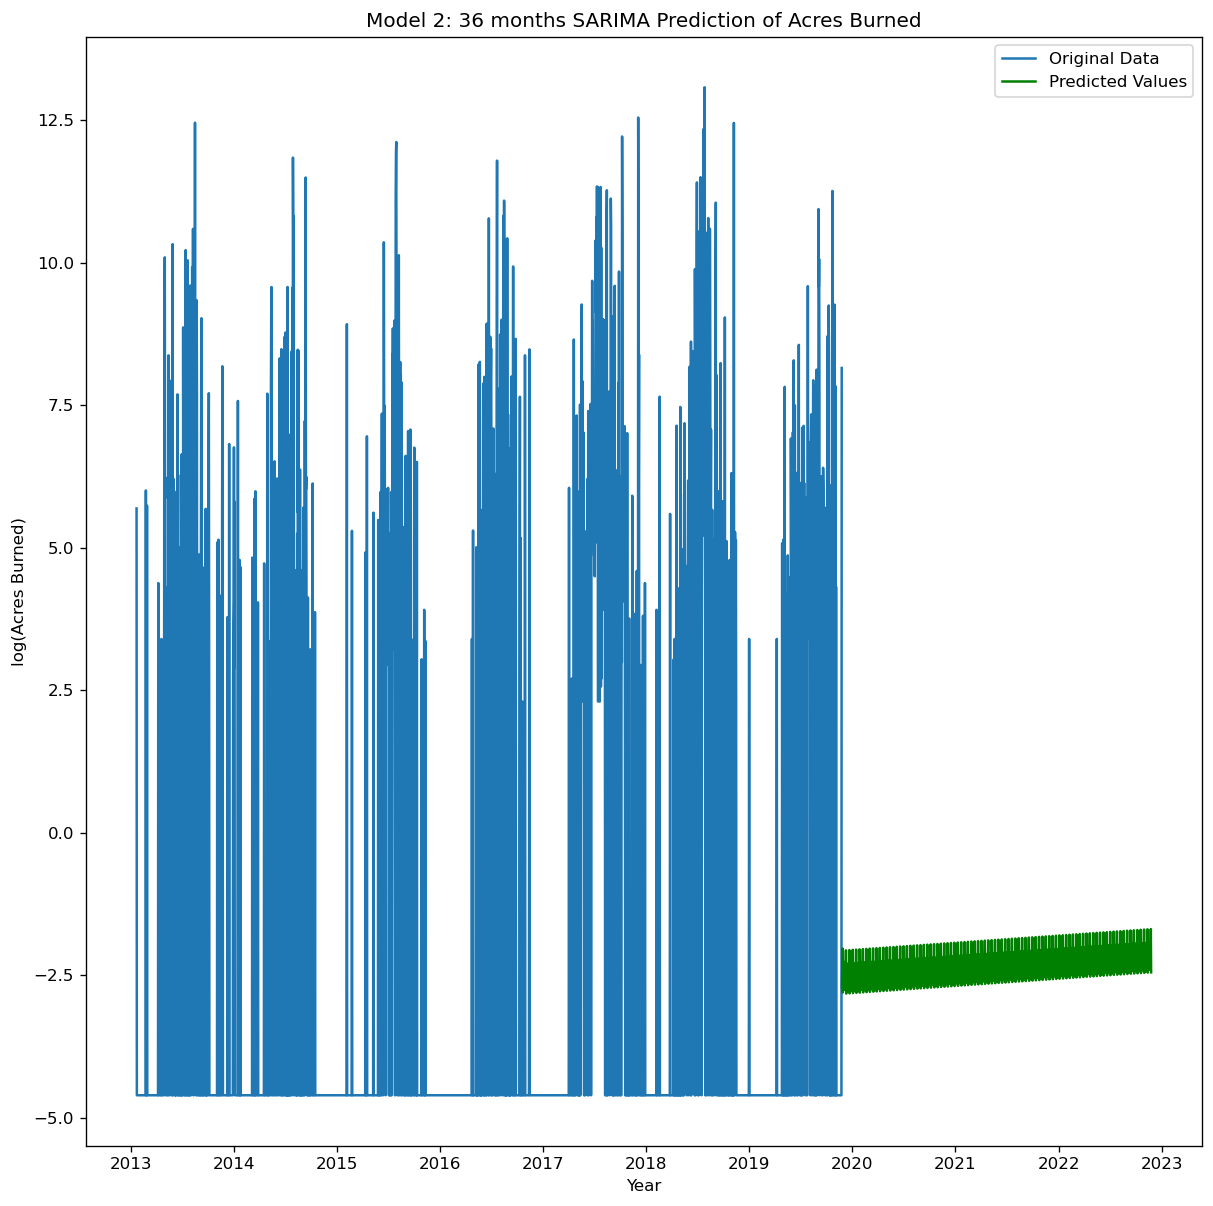

In [91]:
# Plot three years of predicted daily burned acreage 
plt.title('Model 2: 36 months SARIMA Prediction of Acres Burned')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
full_fires_log.plot(label='Original Data')
plt.plot(predictions.index, predictions, color='green', label='Predicted Values')
plt.legend()

## Model 3: Build SARIMA with AutoArima Recommendations

In [92]:
# Use autoarima to determine orders to use in SARIMA model 
pm.auto_arima(full_fires_log, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(2, 0, 1, 12),
      suppress_warnings=True)

In [133]:
# create a train / test split along the time axis 
X = full_fires_log
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [134]:
# fit a Sarima modelk using the recommended orders from autoarima 
model = SARIMAX(train,exog=None, order=(2, 0, 1), seasonal_order=(2, 0, 1, 12))
model_fit = model.fit()

# predict values along test dataset index
yhat = model_fit.predict(start=len(train), end=len(full_fires_log)-1)

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83287D+00    |proj g|=  8.00885D-02

At iterate    5    f=  2.80673D+00    |proj g|=  2.17080D-02

At iterate   10    f=  2.79920D+00    |proj g|=  4.11639D-02

At iterate   15    f=  2.79231D+00    |proj g|=  1.45549D-02

At iterate   20    f=  2.79120D+00    |proj g|=  9.25884D-04

At iterate   25    f=  2.79118D+00    |proj g|=  1.29798D-03

At iterate   30    f=  2.79114D+00    |proj g|=  2.82814D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [135]:
# print model summary statistics 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        AcresBurned   No. Observations:                 1999
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 12)   Log Likelihood               -5579.483
Date:                            Sun, 21 Apr 2024   AIC                          11172.966
Time:                                    19:04:23   BIC                          11212.169
Sample:                                01-22-2013   HQIC                         11187.361
                                     - 07-13-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0904      0.021     51.213      0.000       1.049       1.132
ar.L2         -0.0978      0.020     -4.972      0.000      -0.136      -0.059
ma.L1         -0.9034      0.011    -80.303      0.000      -0.925      -0.881
ar.S.L12       0.6258      0.175      3.572      0.000       0.282       0.969
ar.S.L24       0.0606      0.020      3.059      0.002       0.022       0.099
ma.S.L12      -0.6338      0.176     -3.606      0.000      -0.978      -0.289
sigma2        15.5429      0.556     27.932      0.000      14.452      16.634
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               122.33
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

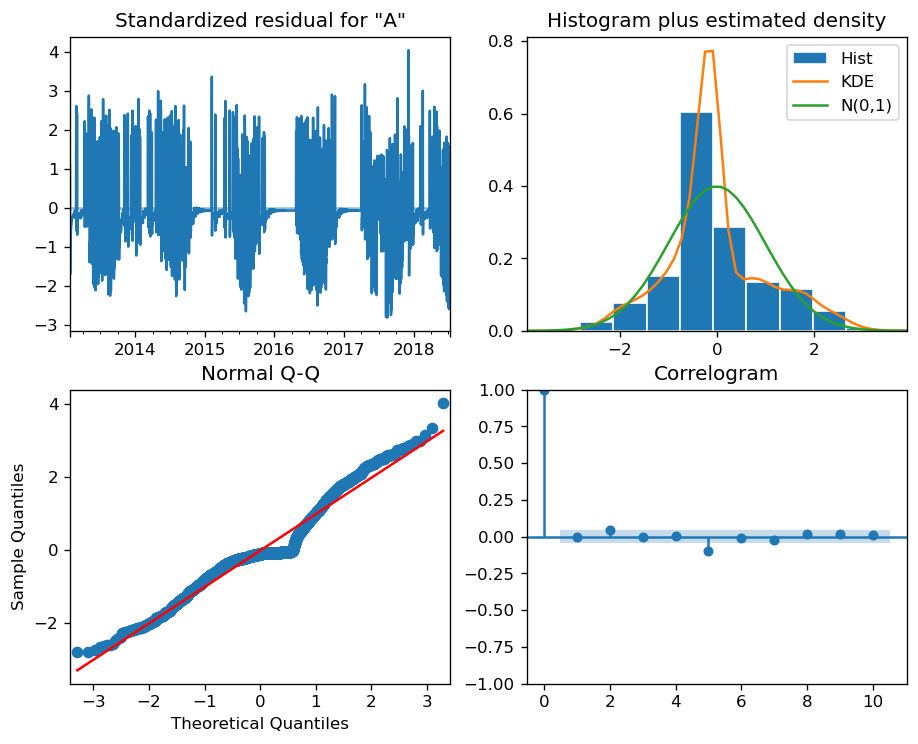

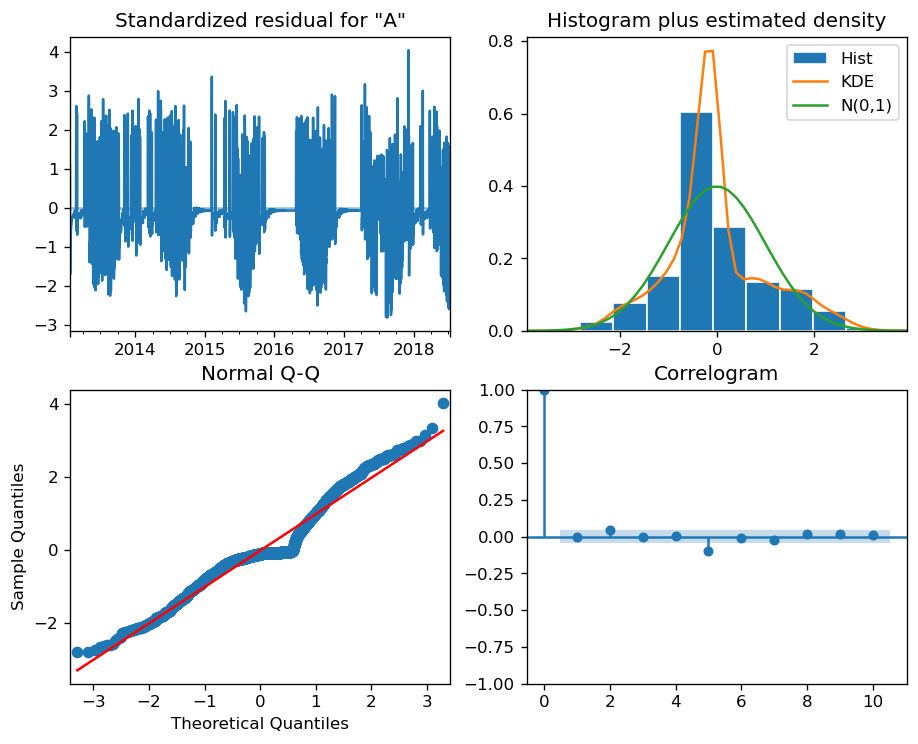

In [96]:
model_fit.plot_diagnostics(figsize=(9,7))

In [97]:
# Calculate the RMSE of the predicted results 
rmse = sqrt(mean_squared_error(test, yhat))
print('Test RMSE:', rmse)

#calculate relative rmse
print('Relative RMSE:',rmse / (max(full_fires_log) - min(full_fires_log)))

Test RMSE: 5.56150602203549
Relative RMSE: 0.3144719942979755


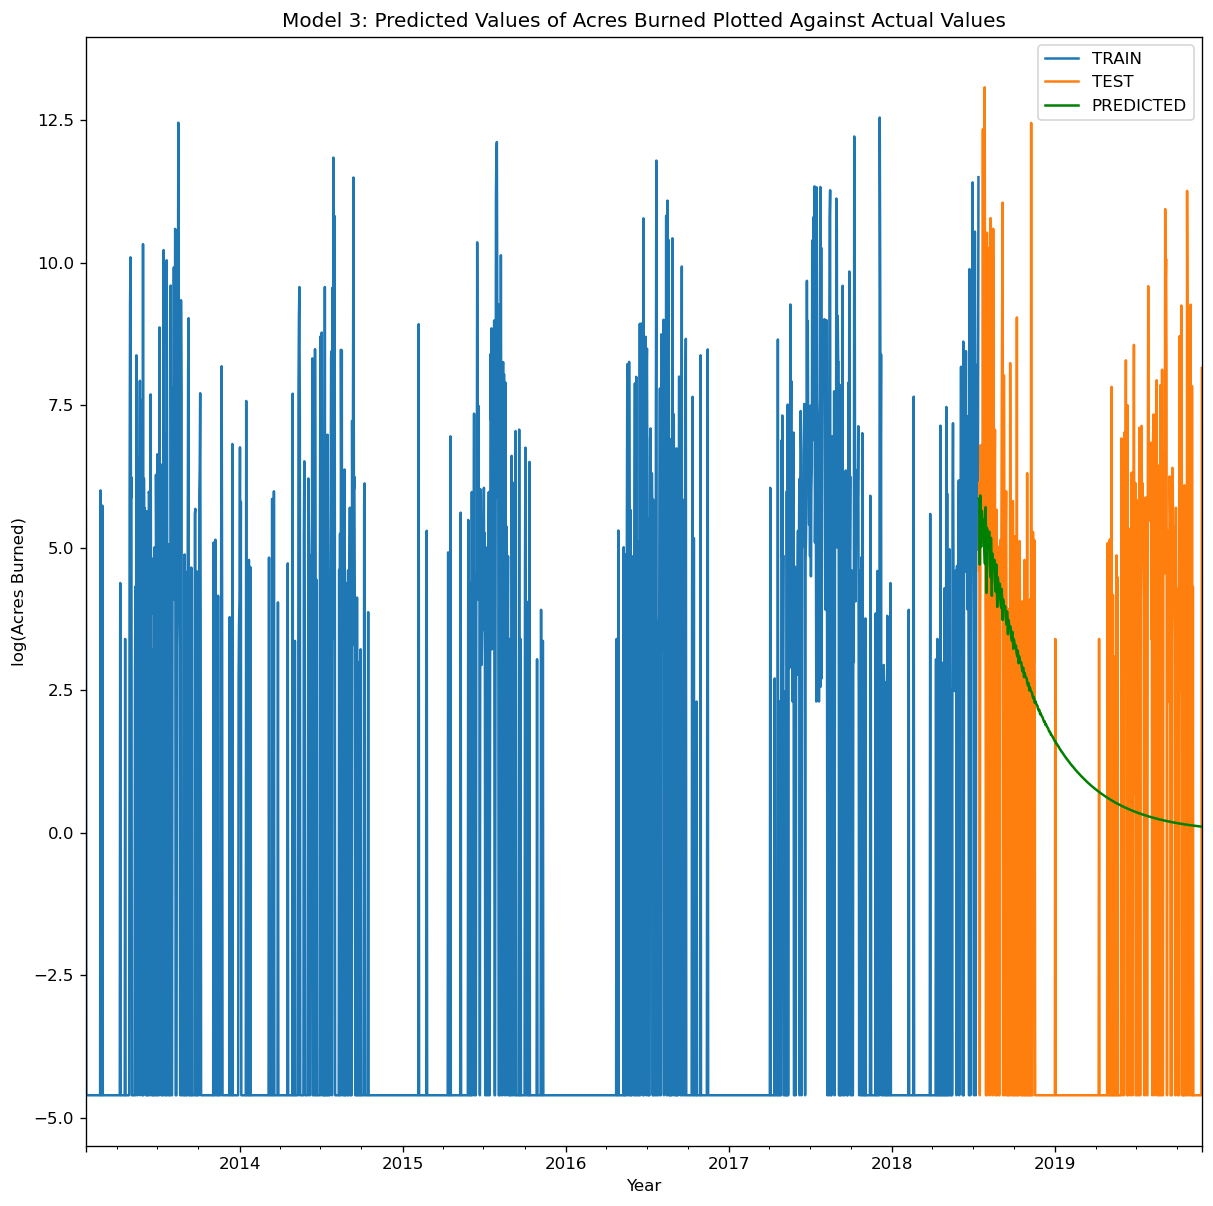

In [136]:
# plot predicted values against test dataset 
plt.title('Model 3: Predicted Values of Acres Burned Plotted Against Actual Values')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
train.plot(label='TRAIN')
test.plot(label='TEST')
plt.plot(yhat.index, yhat, color='green', label='PREDICTED')
plt.legend()

In [99]:
# Fit a model with the full dataset 
model = SARIMAX(full_fires_log,exog=None, order=(2, 0, 1), seasonal_order=(2, 0, 1, 12))

model_fit = model.fit()

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84244D+00    |proj g|=  6.71884D-02

At iterate    5    f=  2.80989D+00    |proj g|=  7.34107D-03

At iterate   10    f=  2.80861D+00    |proj g|=  7.42140D-03

At iterate   15    f=  2.80532D+00    |proj g|=  7.64447D-03

At iterate   20    f=  2.80492D+00    |proj g|=  3.85434D-04

At iterate   25    f=  2.80486D+00    |proj g|=  2.12040D-03

At iterate   30    f=  2.80481D+00    |proj g|=  1.00438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [100]:
#use fitted model to generate three years of predicted values 
predictions = model_fit.predict(start=len(full_fires_log), end=len(full_fires_log)+1095)

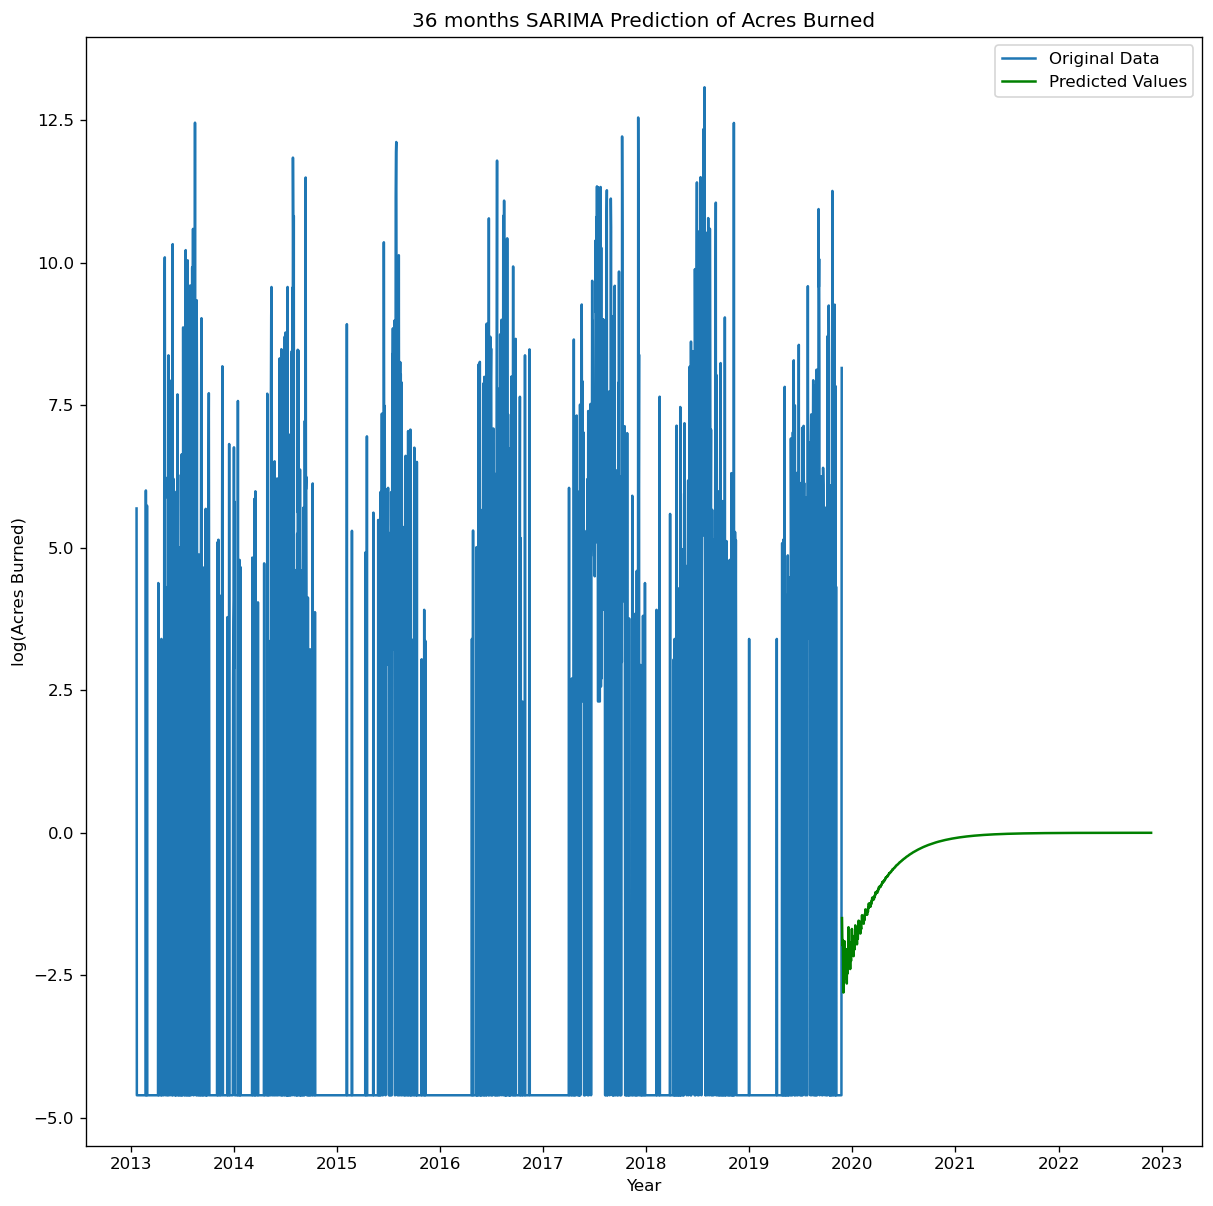

In [101]:
# Plot three years of predicted daily burned acreage 
plt.title('36 months SARIMA Prediction of Acres Burned')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
plt.plot(full_fires_log, label='Original Data')
plt.plot(predictions.index, predictions, color='green', label='Predicted Values')
plt.legend()

## Model 4: ARIMA model with walk forward validation 

In [102]:
# use autoarima to determine the optimal orders 
aamodel = pm.auto_arima(full_fires_log, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=14048.391, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=15318.015, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=14612.965, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14887.451, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=14037.198, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=14394.735, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=14037.329, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=14052.387, Time=0.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=14038.017, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=14285.203, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=14036.964, Time=0.37 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=14038.949, Time=0.58 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=14037.016, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0]  

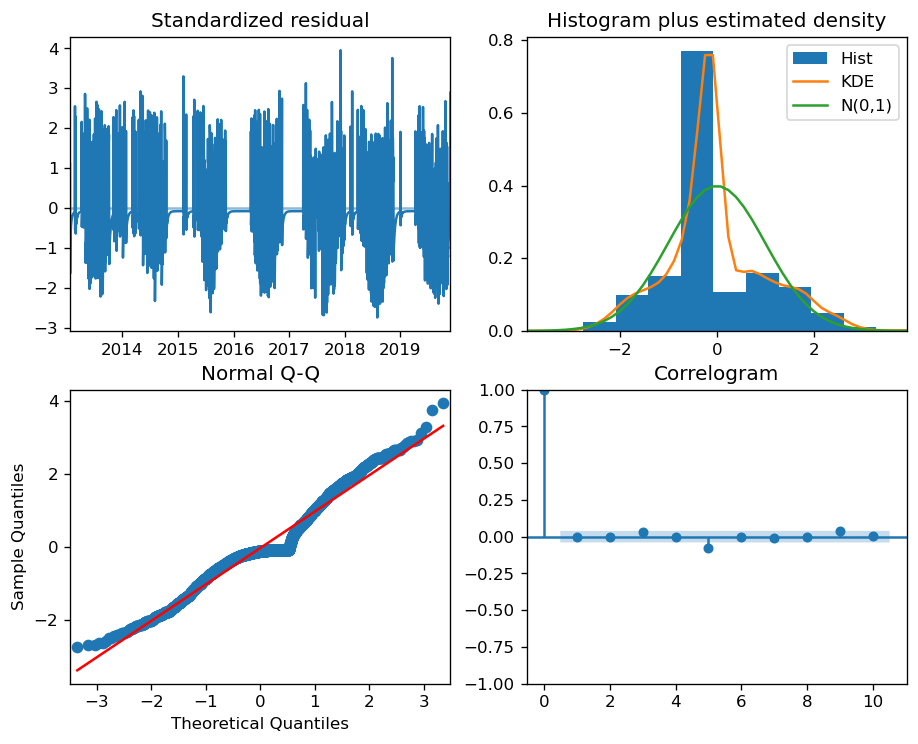

In [103]:
# plot the residual plots of the model
aamodel.plot_diagnostics(figsize=(9,7))
plt.show()

In [104]:
# model the log of acres burned
X = full_fires_log
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# calculate rmse
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE:', rmse)

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 4.22464056813887


In [105]:
#calculate relative rmse
print('Relative RMSE:',rmse / (max(full_fires_log) - min(full_fires_log)))

Relative RMSE: 0.2388797457722657


In [106]:
# print model summary statistics 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2498
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7004.926
Date:                Wed, 17 Apr 2024   AIC                          14023.853
Time:                        14:07:28   BIC                          14064.615
Sample:                             0   HQIC                         14038.652
                               - 2498                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4579      1.486     -0.981      0.327      -4.371       1.455
ar.L1          0.2884      0.153      1.887      0.059      -0.011       0.588
ar.L2          0.7871      0.153      5.137      0.000       0.487       1.087
ar.L3         -0.0901      0.018     -4.957      0.000      -0.126      -0.054
ma.L1         -0.1167      0.153     -0.763      0.445      -0.416       0.183
ma.L2         -0.7079      0.135     -5.239      0.000      -0.973      -0.443
sigma2        15.9603      0.586     27.228      0.000      14.811      17.109
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               105.32
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.44
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

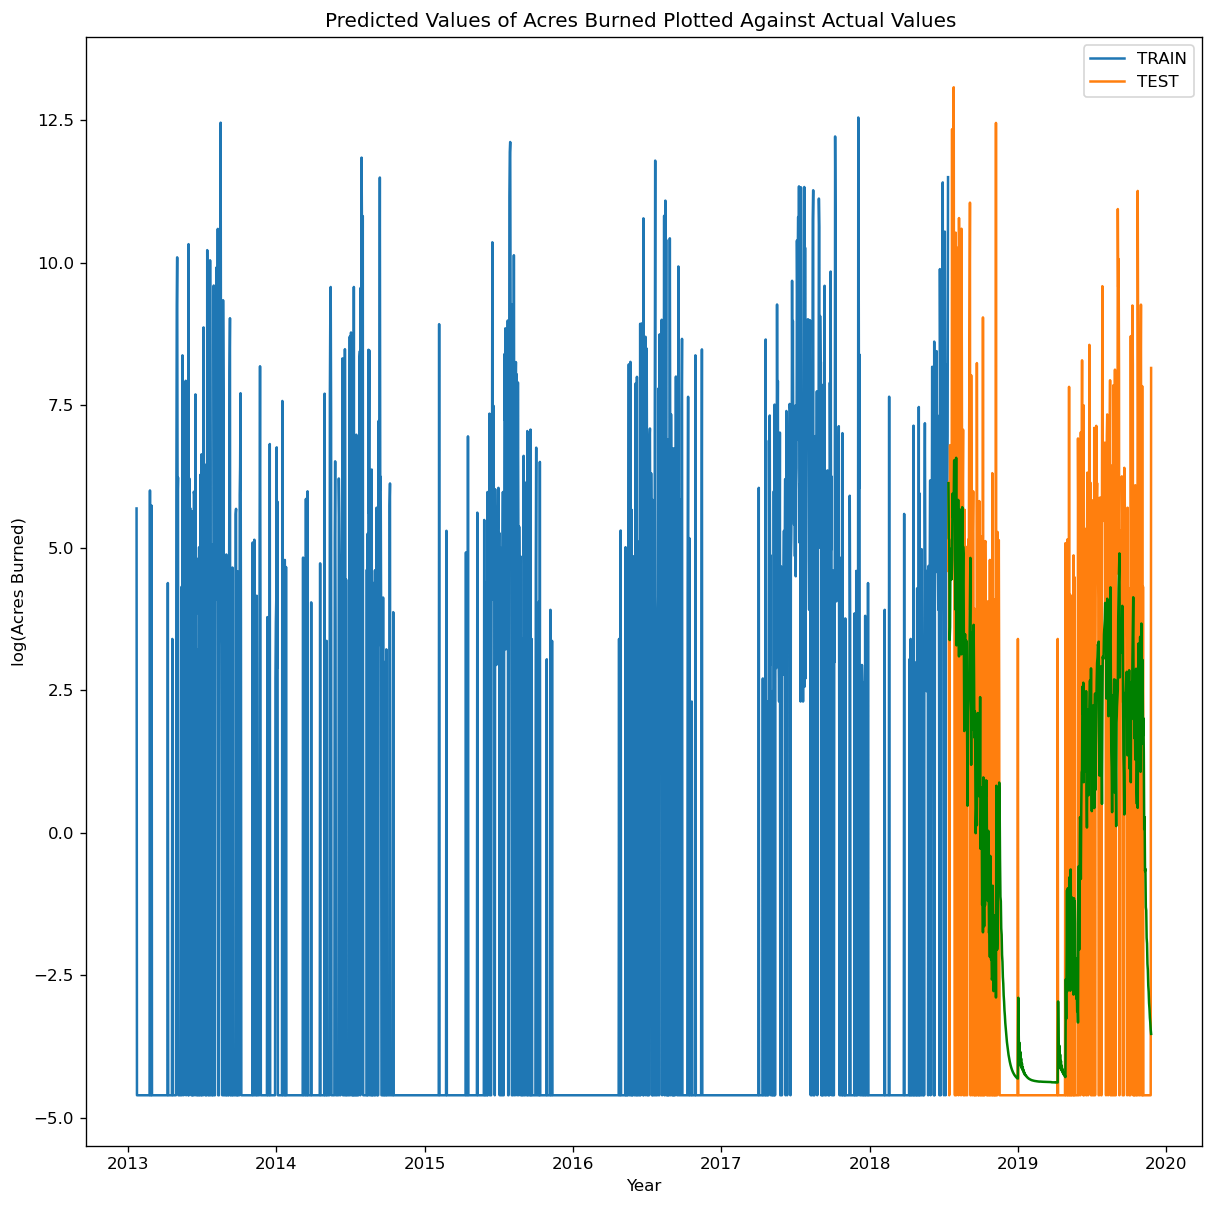

In [107]:
# plot predicted data against test data 
plt.title('Model 4: Predicted Values of Acres Burned Plotted Against Actual Values ')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')
plt.plot(X[size:len(X)].index, predictions, color='green')

In [108]:
# fit model with full data set 
model = ARIMA(full_fires_log, order=(3,0,2))
model_fit = model.fit()

# predict three years of data with fitted model 
prediction = model_fit.predict(start=len(full_fires_log), end=len(full_fires_log)+1095)

/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/christopher/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/

<Axes: title={'center': '36 months ARIMA Prediction of Acres Burned'}, xlabel='Year', ylabel='log(Acres Burned)'>

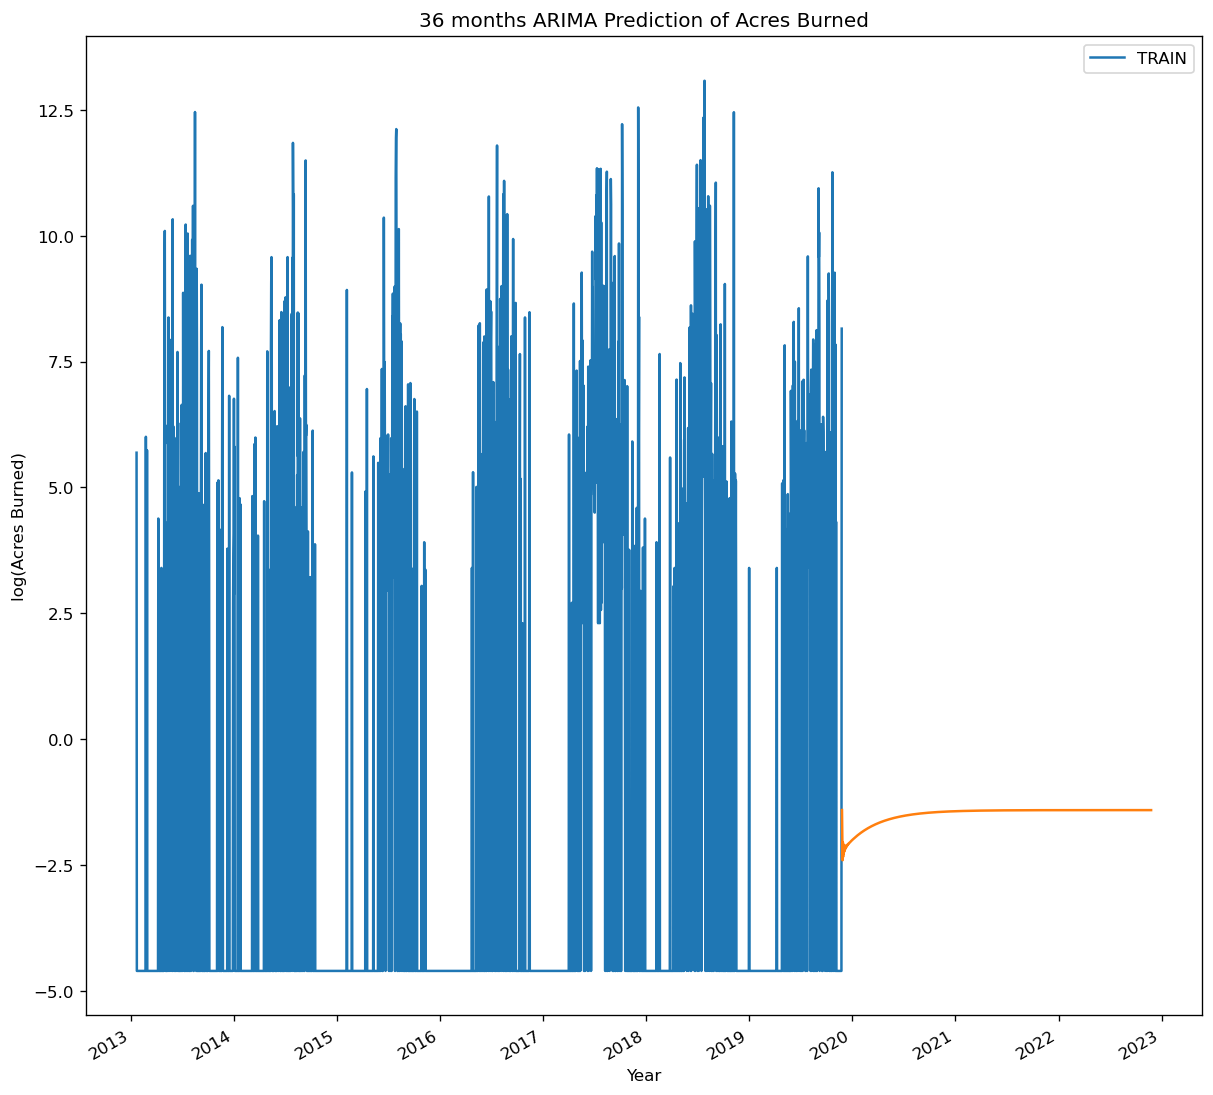

In [109]:
# plot predicted values with original dataset
plt.title('36 months ARIMA Prediction of Acres Burned')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
plt.plot(full_fires_log, label='Original Data')
plt.plot(predictions.index, predictions, color='green', label='Predicted Values')
plt.legend()

## Model 5: Sarima Model with Acres Burned Aggregated Monthly

In [110]:
# Group the data by monthly sum of acres burned 
full_fires_log.index = pd.to_datetime(full_fires_log.index)
fflog_month = full_fires_log.groupby(pd.Grouper(freq='M')).sum()

<Axes: >

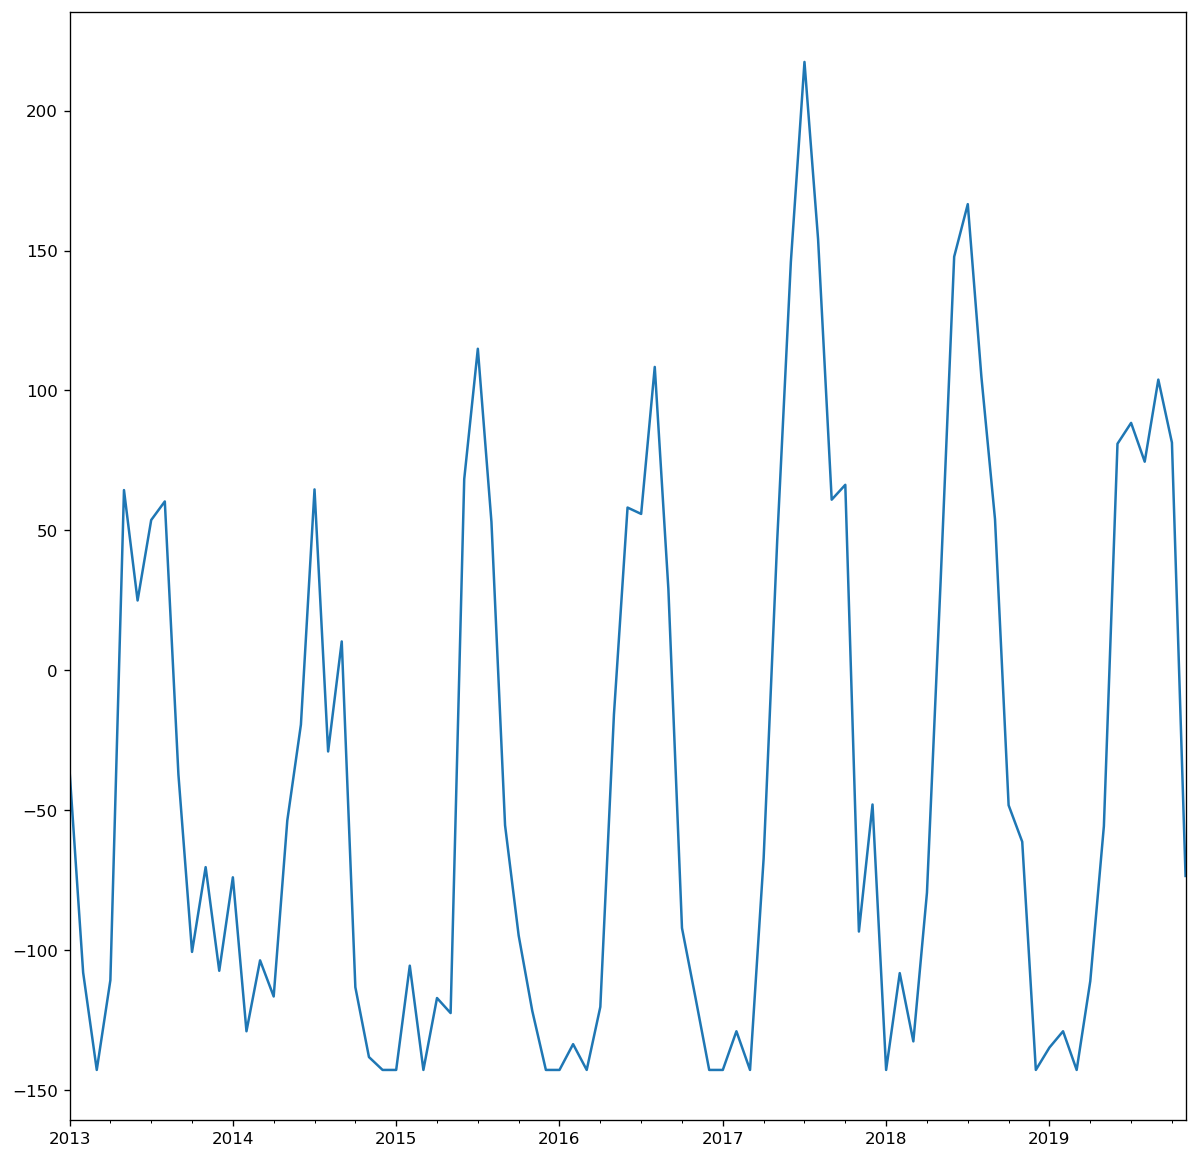

In [111]:
# plot the monthly sum of acresburned
fflog_month.plot()

In [112]:
# use autoarima to find ideal model orders 
pm.auto_arima(fflog_month, start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=12, 
                         start_P=0, 
                         seasonal=True,
                         d=None, 
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [137]:
# create a train / test split along the time axis 
X = fflog_month
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [138]:
# fit a Sarimax model with recommended orders 
model = SARIMAX(train,exog=None, order=(2, 0, 0), seasonal_order=(1, 0, 1, 12))

model_fit = model.fit()

# run model predictions over the index of the test data set
yhat = model_fit.predict(start=len(train), end=len(fflog_month)-1)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57455D+00    |proj g|=  1.87736D-02

At iterate    5    f=  5.47074D+00    |proj g|=  1.25814D-02

At iterate   10    f=  5.44974D+00    |proj g|=  1.40158D-01

At iterate   15    f=  5.42563D+00    |proj g|=  1.00248D-02

At iterate   20    f=  5.41329D+00    |proj g|=  8.03448D-02

At iterate   25    f=  5.39622D+00    |proj g|=  1.42524D-02

At iterate   30    f=  5.39573D+00    |proj g|=  7.75074D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

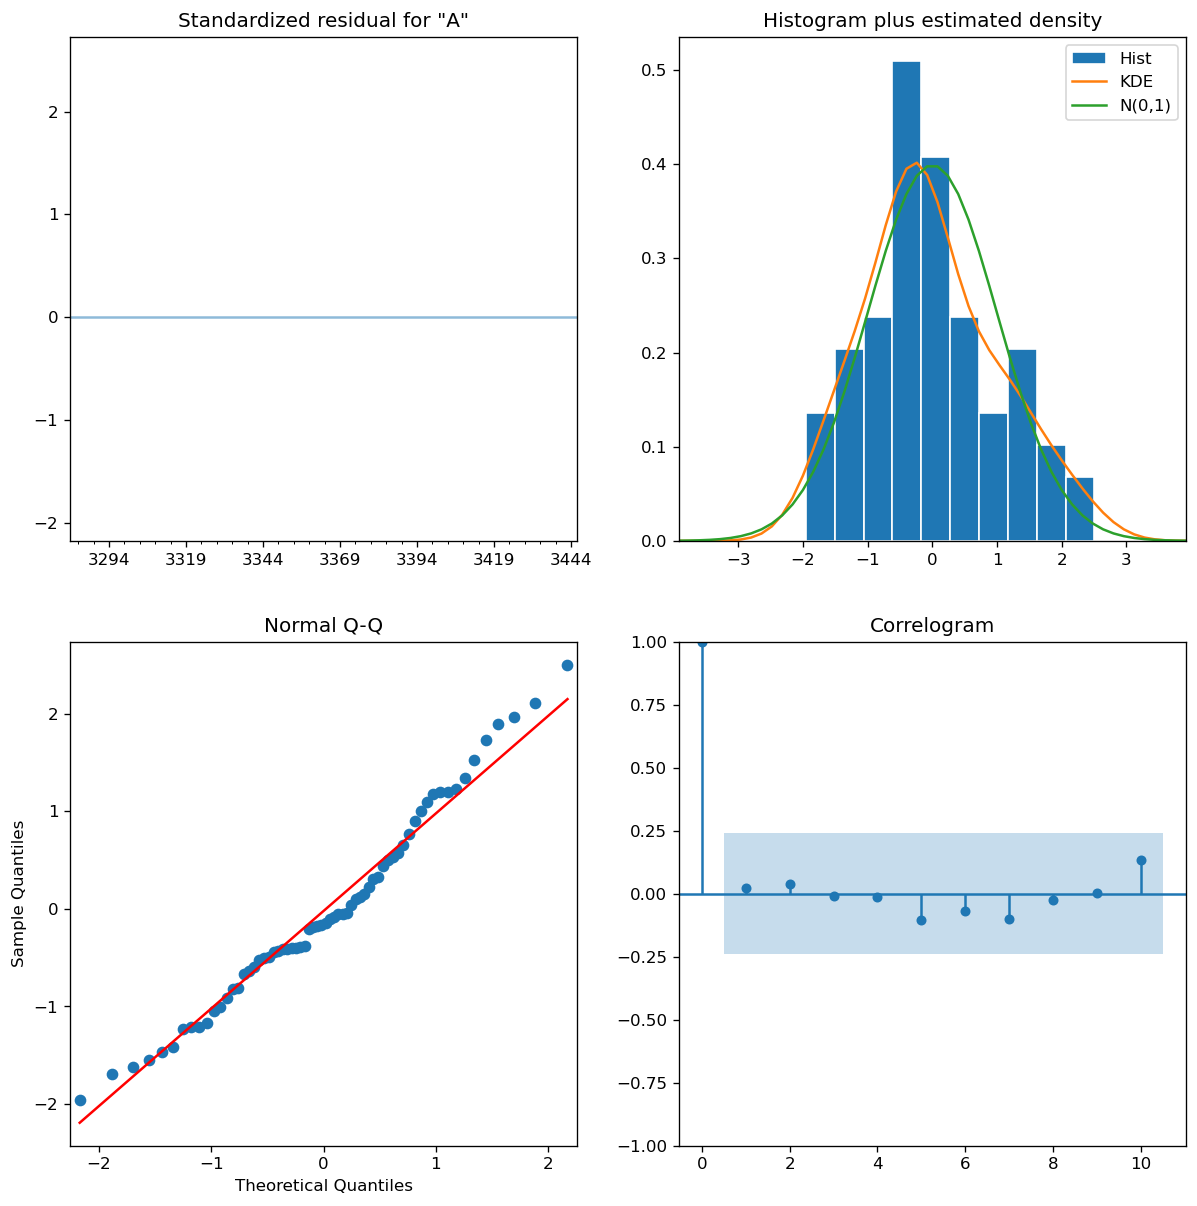

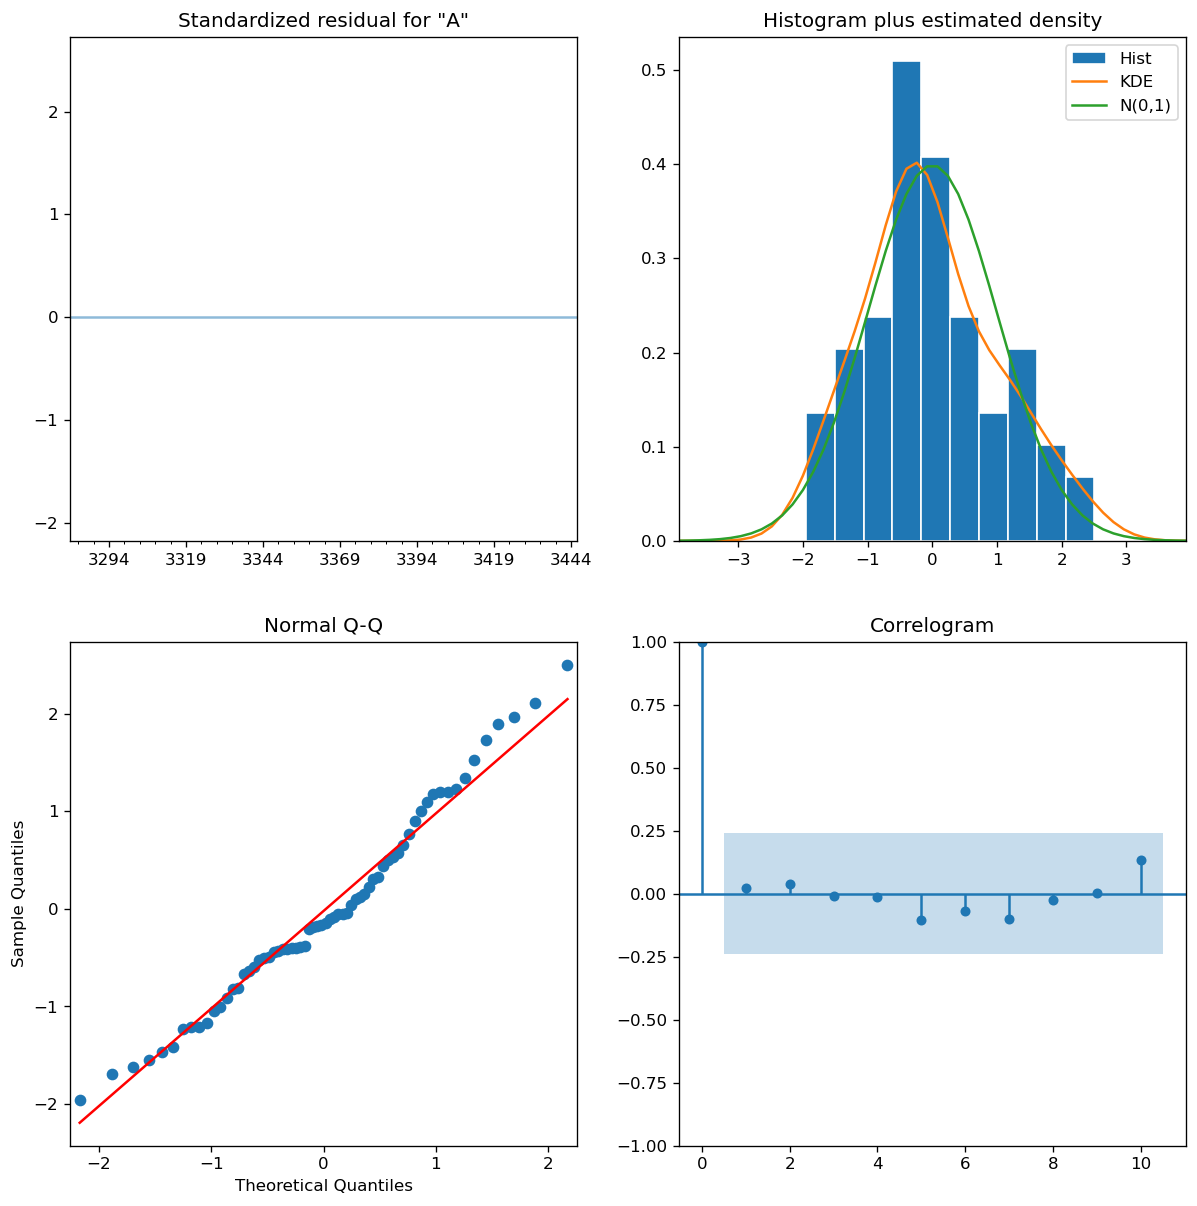

In [115]:
model_fit.plot_diagnostics()

In [139]:
#print model summary statistics 
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          AcresBurned   No. Observations:                   66
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -356.118
Date:                              Sun, 21 Apr 2024   AIC                            722.236
Time:                                      19:05:41   BIC                            733.185
Sample:                                  01-31-2013   HQIC                           726.563
                                       - 06-30-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4151      0.110      3.777      0.000       0.200       0.631
ar.L2          0.2042      0.136      1.502      0.133      -0.062       0.471
ar.S.L12       0.9282      0.080     11.585      0.000       0.771       1.085
ma.S.L12      -0.4973      0.248     -2.009      0.045      -0.983      -0.012
sigma2      2348.1964    486.672      4.825      0.000    1394.337    3302.055
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.16
Prob(Q):                              0.84   Prob(JB):                         0.34
Heteroskedasticity (H):               1.10   Skew:                             0.41
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
# Calculate the RMSE of the predicted results 
rmse = sqrt(mean_squared_error(test, yhat))
print('Test RMSE:', rmse)

#calculate relative rmse
print('Relative RMSE:',rmse / (max(fflog_month) - min(fflog_month)))

Test RMSE: 44.01833975220144
Relative RMSE: 0.12222608101844365


<Axes: title={'center': 'Model 5: Prediction of Acres Burned with Monthly Data'}, xlabel='Year', ylabel='log(Acres Burned)'>

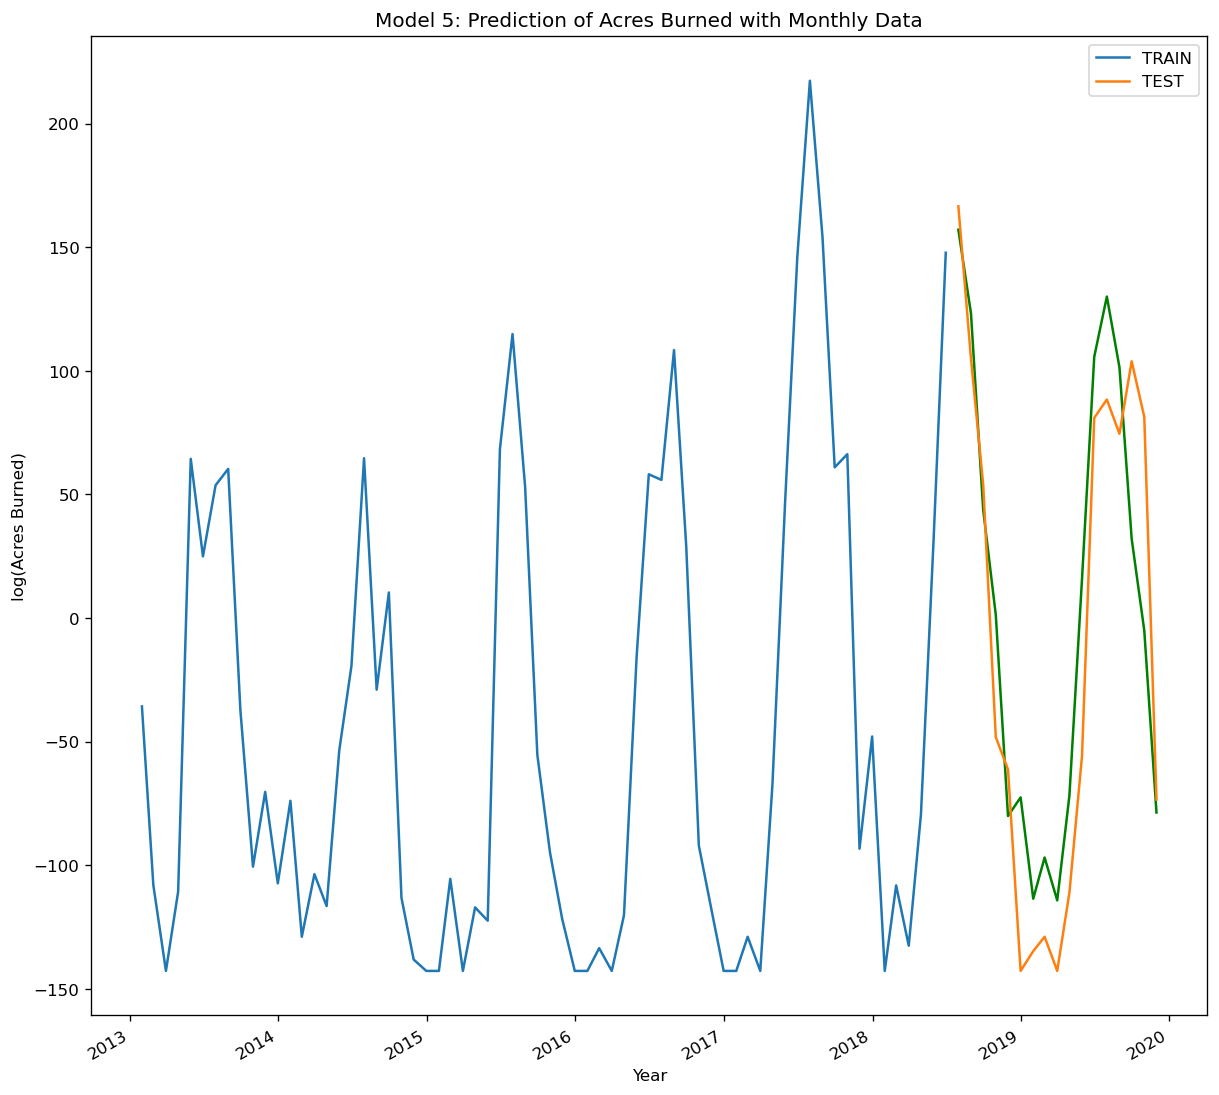

In [140]:
# plot the predicted data against the test data set 
plt.title('Model 5: Prediction of Acres Burned with Monthly Data')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
plt.plot(yhat.index, yhat, color='green', label='Predicted Value')
train.plot(legend=True, label='TRAIN')
test.plot(legend=True, label='TEST')

In [119]:
# fit model trained with complete dataset
model = SARIMAX(fflog_month,exog=None, order=(2, 0, 0), seasonal_order=(1, 0, 1, 12))

model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49071D+00    |proj g|=  2.28618D-01

At iterate    5    f=  5.40334D+00    |proj g|=  7.76182D-03

At iterate   10    f=  5.39284D+00    |proj g|=  1.21022D-02

At iterate   15    f=  5.35390D+00    |proj g|=  4.83841D-02

At iterate   20    f=  5.34989D+00    |proj g|=  1.67075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   7.123D-06   5.350D+00
  F =   5.3498940759216529     

CONVERG

 This problem is unconstrained.


In [120]:
# Generate three years of predicted acres burned 
predictions = model_fit.predict(start=len(fflog_month), end=len(fflog_month)+36)

<Axes: title={'center': '36 months of Predicted Burned Acreage by Month'}, xlabel='Year', ylabel='log(Acres Burned)'>

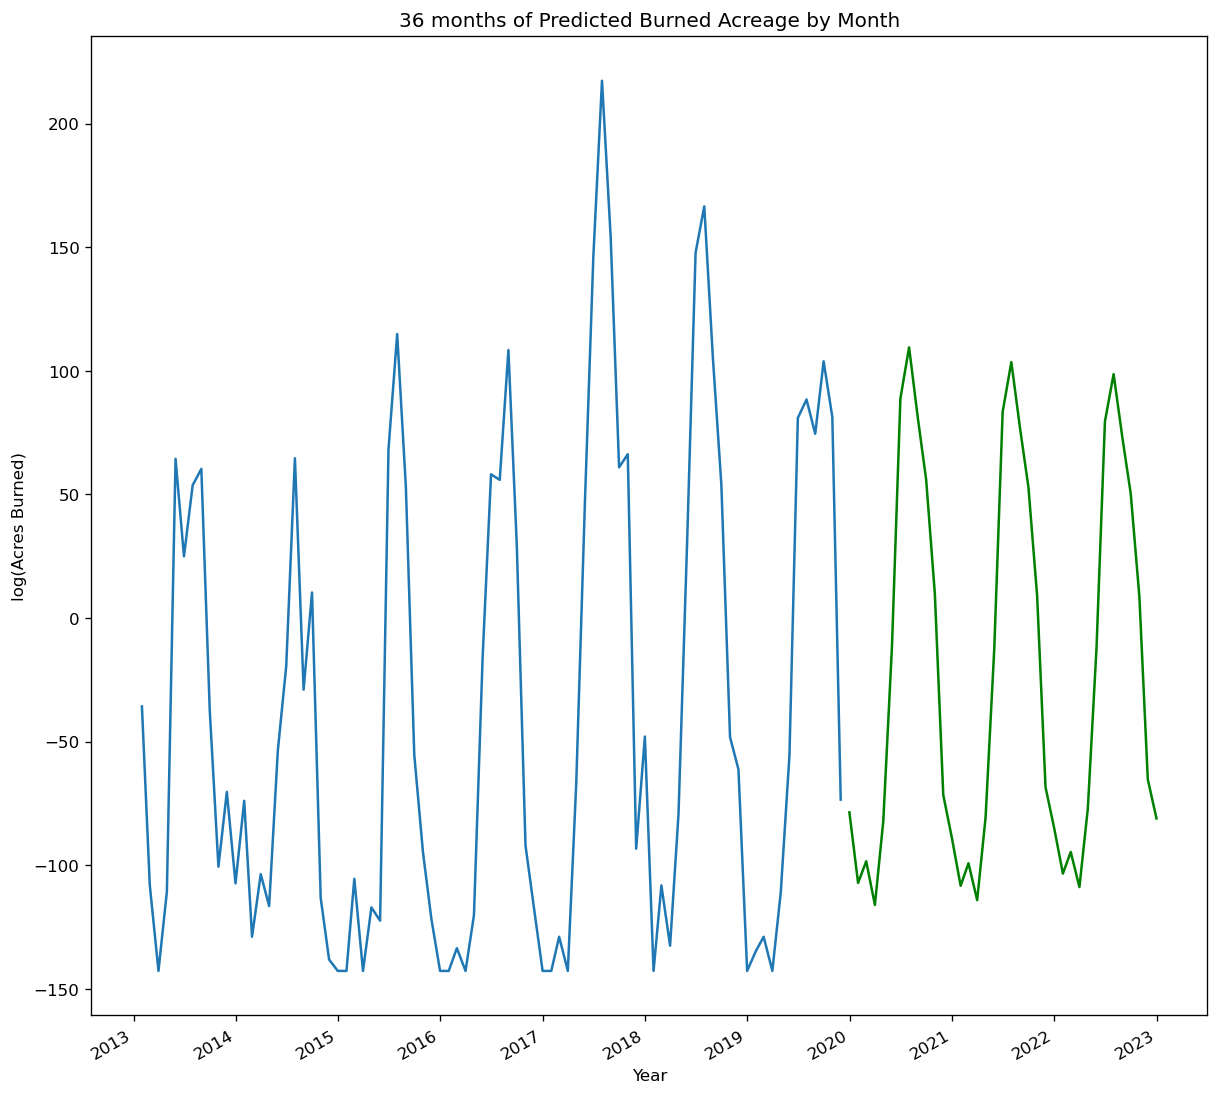

In [121]:
# plot the original dataset and predicted future values 
plt.title('36 months of Predicted Burned Acreage by Month')
plt.ylabel('log(Acres Burned)')
plt.xlabel('Year')
plt.plot(predictions.index, predictions, color='green', label='Predicted Values')
fflog_month.plot(label='Original Data')
plt.legend()

In [122]:
real_predict = np.exp(predictions)
real_predict

2019-12-31    7.284105e-35
2020-01-31    2.902054e-47
2020-02-29    1.820092e-43
2020-03-31    3.853716e-51
2020-04-30    2.213512e-36
2020-05-31    1.133122e-05
2020-06-30    3.676864e+38
2020-07-31    3.662538e+47
2020-08-31    1.827977e+35
2020-09-30    1.939480e+24
2020-10-31    1.799078e+04
2020-11-30    8.200491e-32
2020-12-31    2.068063e-39
2021-01-31    8.978498e-48
2021-02-28    8.315344e-44
2021-03-31    2.733260e-50
2021-04-30    8.337018e-36
2021-05-31    3.416418e-06
2021-06-30    1.718141e+36
2021-07-31    9.392235e+44
2021-08-31    2.271168e+33
2021-09-30    9.382611e+22
2021-10-31    8.506331e+03
2021-11-30    1.894054e-30
2021-12-31    1.149830e-37
2022-01-31    1.280851e-45
2022-02-28    7.978138e-42
2022-03-31    5.378368e-48
2022-04-30    3.505623e-34
2022-05-31    6.005263e-06
2022-06-30    3.429206e+34
2022-07-31    7.360939e+42
2022-08-31    6.231134e+31
2022-09-30    7.884246e+21
2022-10-31    5.551834e+03
2022-11-30    4.619195e-29
2022-12-31    6.099302e-36
F

# Global Fire Data

In [123]:
global_fires.head()

,ID,Initialdate,Finaldate,Area_ha,Area_m2,Area_Km2,CountryName,Continent,Region
0,25078590,2022/01/09 00:00,2022/02/06 00:00,50232.10763,502321076.3,502.321076,Ghana,Africa,Western Africa
1,25079092,2022/01/11 00:00,2022/02/08 00:00,82380.29538,823802953.8,823.802954,Nigeria,Africa,Western Africa
2,25079113,2022/01/11 00:00,2022/02/03 00:00,36851.12748,368511274.8,368.511275,Nigeria,Africa,Western Africa
3,25083241,2022/01/03 00:00,2022/02/12 00:00,43303.63519,433036351.9,433.036352,Nigeria,Africa,Western Africa
4,25095507,2022/01/01 00:00,2022/02/11 00:00,75753.14059,757531405.9,757.531406,Central African Republic,Africa,Middle Africa


In [124]:
global_fires.shape

(319278, 9)

In [125]:
global_fires.describe()

,ID,Area_ha,Area_m2,Area_Km2
count,3.192780e+05,3.192780e+05,3.192780e+05,319278.000000
mean,2.557438e+07,8.783306e+02,8.783306e+06,8.783306
std,3.006964e+05,1.375650e+04,1.375650e+08,137.564988
min,2.503646e+07,1.068460e+02,1.068460e+06,1.068460
25%,2.533053e+07,1.496636e+02,1.496636e+06,1.496636
50%,2.557625e+07,2.565107e+02,2.565107e+06,2.565107
75%,2.581172e+07,5.349487e+02,5.349487e+06,5.349487
max,2.610613e+07,6.092464e+06,6.092464e+10,60924.643560


# Fire Cost Data

In [37]:
fire_cost = pd.read_csv('data/Federal Firefighting Costs (Suppression Only).csv')

In [38]:
fire_cost.head()

,Year,Fires,Acres,ForestService,DOIAgencies,Total
0,1985,"82,591","2,896,147","$161,505,000","$78,438,000","$239,943,000"
1,1986,"85,907","2,719,162","$111,625,000","$91,153,000","$202,778,000"
2,1987,"71,300","2,447,296","$253,657,000","$81,452,000","$335,109,000"
3,1988,"72,750","5,009,290","$429,609,000","$149,317,000","$578,926,000"
4,1989,"48,949","1,827,310","$331,672,000","$168,115,000","$499,787,000"


In [39]:
fire_cost.shape

(36, 6)

In [40]:
fire_cost.dtypes

Year              int64
Fires            object
Acres            object
ForestService    object
DOIAgencies      object
Total            object
dtype: object

In [41]:
# remove punctuation and convert to integer data type 
for x in range(0, len(fire_cost['Acres'])):
    fire_cost['Acres'][x] = fire_cost['Acres'][x].translate(str.maketrans('', '', string.punctuation))
   
fire_cost['Acres'] = fire_cost['Acres'].values.astype("float64")

In [42]:
# remove punctuation and convert to integer data type 
for x in range(0, len(fire_cost['Total'])):
    fire_cost['Total'][x] = fire_cost['Total'][x].translate(str.maketrans('', '', string.punctuation))
   
fire_cost['Total'] = fire_cost['Total'].values.astype("float64")

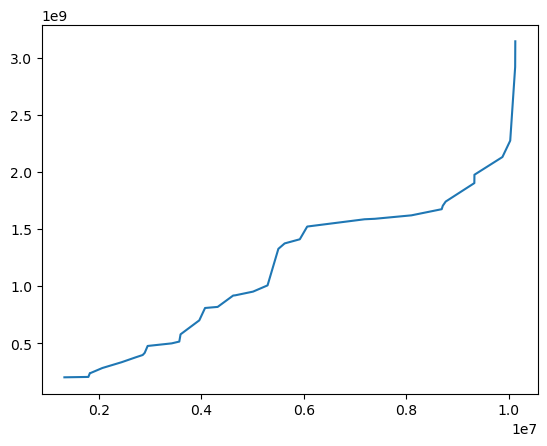

In [43]:
plt.plot(fire_cost['Acres'].sort_values(), fire_cost['Total'].sort_values())

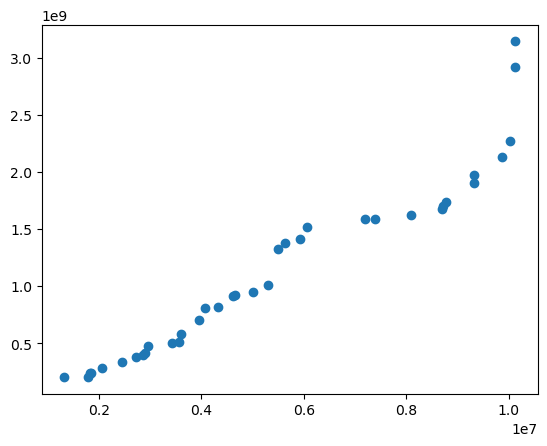

In [44]:
plt.scatter(fire_cost['Acres'].sort_values(), fire_cost['Total'].sort_values())

In [45]:
fire_cost.corr()

,Year,Acres,Total
Year,1.000000,0.642506,0.857381
Acres,0.642506,1.000000,0.748912
Total,0.857381,0.748912,1.000000
